In [1]:
from tools_stance import * 
from models import *
import torch 
import pandas as pd

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

path="../Datasets/CSV_Harassment/"
train =pd.read_csv(path + "train_format.csv")
val=pd.read_csv(path + "val_format.csv")
test=pd.read_csv(path + "test_format.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


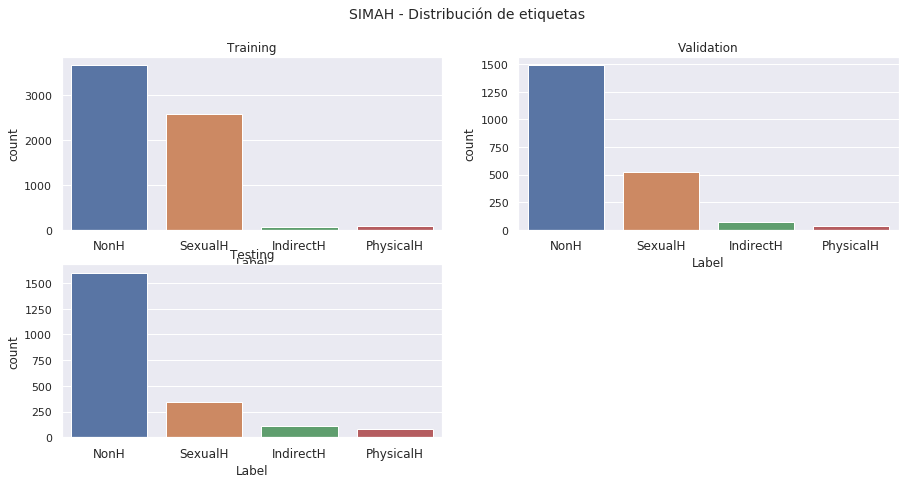

In [2]:
import seaborn as sns
sns.set(font_scale=1)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,7))
j=220
labs=["NonH", "SexualH", "IndirectH", "PhysicalH"]
data=[train['Label'], val['Label'], test["Label"]]
name=["Training", "Validation", "Testing"]
for i in range(3):
    j+=1
    h=fig.add_subplot(j)
    ax= sns.countplot(data[i], order=labs)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    h.title.set_text(str(name[i]))

fig.suptitle("SIMAH - Distribución de etiquetas", fontsize=14)
plt.show()

In [3]:
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ":",acc)  
    print ("F1-score None", name_model, ":",f1)
    print ("F1-score macro", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ":",acc)  
    print ("F1-score None", name_model, ":",f1)
    print ("F1-score macro", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ":",acc_t)  
    print ("F1-score None", name_model, ":",f1_t)
    print ("F1-score macro", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [4]:
tokenizer_loaded = BertTokenizer.from_pretrained("bert-base-uncased")
model_loaded = BertForSequenceClassification.from_pretrained("bert-base-uncased",  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
token_2_idx = {value : key for (key, value) in idx_2_token.items()}

In [5]:
MAX_LEN = 34
EMB_matrix= model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(30522, 768)

In [6]:
ids_train=train['tweet_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
#class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)

ids_val=val['tweet_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['tweet_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

Pesos de clases: [ 0.43526359 28.97272727 20.96710526  0.61715724]


In [7]:
sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

In [8]:
input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

In [9]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

In [10]:
emb=768

In [11]:
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [12]:
x_train.shape

(6374, 34, 768)

In [13]:
x_test.shape

(2123, 34, 768)

## Original - No aumento


Entrenando exec  1 



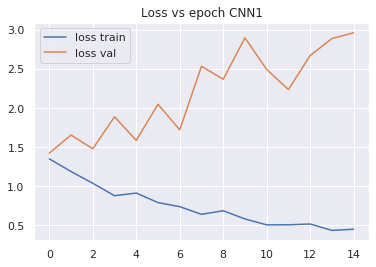

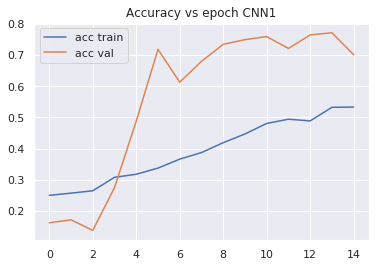


------ Training ------
Accuracy cnn1 : 0.7241920301223721
F1-score None cnn1 : [0.78385284 0.70588235 0.71523179 0.62421757]
F1-score macro cnn1 : 0.70729613665085

------ Validation ------
Accuracy cnn1 : 0.7007058823529412
F1-score None cnn1 : [0.80161943 0.02564103 0.04761905 0.51286449]
F1-score macro cnn1 : 0.3469360001137558

------ Testing ------
Accuracy cnn1 : 0.6862929816297691
F1-score None cnn1 : [0.80660066 0.03603604 0.02564103 0.45180136]
F1-score macro cnn1 : 0.3300197712342091


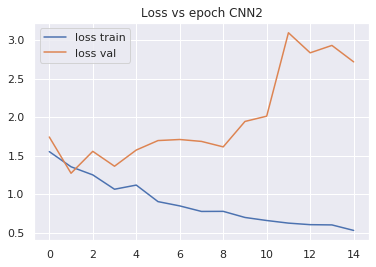

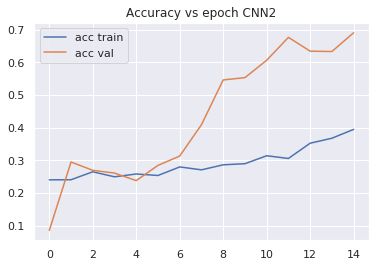


------ Training ------
Accuracy cnn2 : 0.6352368999058676
F1-score None cnn2 : [0.75901974 0.63829787 0.25       0.35621948]
F1-score macro cnn2 : 0.5008842727056968

------ Validation ------
Accuracy cnn2 : 0.6908235294117647
F1-score None cnn2 : [0.81849209 0.06818182 0.07272727 0.34258142]
F1-score macro cnn2 : 0.32549565060686036

------ Testing ------
Accuracy cnn2 : 0.7060763071125765
F1-score None cnn2 : [0.83618876 0.16176471 0.15384615 0.26426426]
F1-score macro cnn2 : 0.35401597065854745


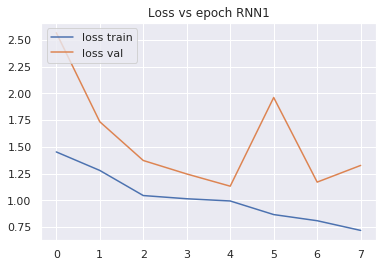

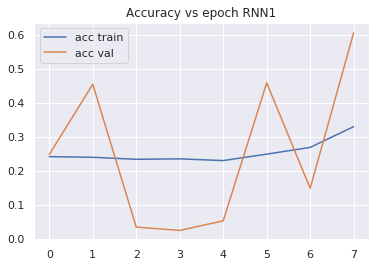


------ Training ------
Accuracy rnn1 : 0.5552243489174773
F1-score None rnn1 : [0.74090801 0.08499096 0.06779661 0.24188791]
F1-score macro rnn1 : 0.28389587116041265

------ Validation ------
Accuracy rnn1 : 0.6070588235294118
F1-score None rnn1 : [0.77788945 0.16014898 0.03076923 0.25641026]
F1-score macro rnn1 : 0.30630447755177553

------ Testing ------
Accuracy rnn1 : 0.5963259538389072
F1-score None rnn1 : [0.76261429 0.17802503 0.07407407 0.30901288]
F1-score macro rnn1 : 0.33093156873326257


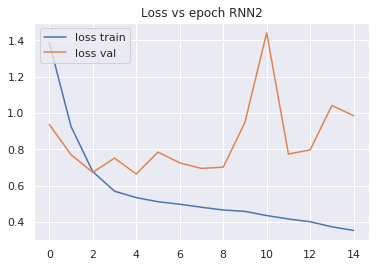

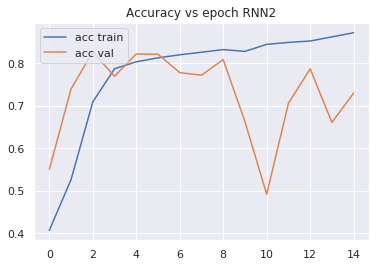


------ Training ------
Accuracy rnn2 : 0.8951992469406965
F1-score None rnn2 : [0.92878999 0.31451613 0.2027027  0.89616428]
F1-score macro rnn2 : 0.5855432738096527

------ Validation ------
Accuracy rnn2 : 0.7298823529411764
F1-score None rnn2 : [0.82131207 0.16901408 0.06060606 0.62977397]
F1-score macro rnn2 : 0.42017654549193967

------ Testing ------
Accuracy rnn2 : 0.6900612341026848
F1-score None rnn2 : [0.80576045 0.18957346 0.11881188 0.53725851]
F1-score macro rnn2 : 0.4128510750398595


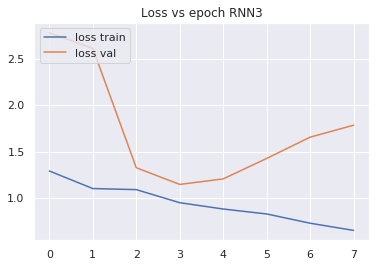

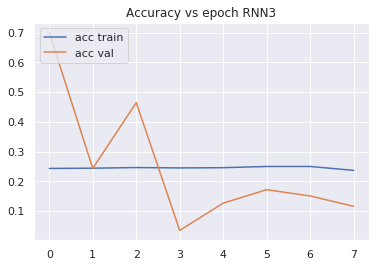


------ Training ------
Accuracy rnn3 : 0.1732036397866332
F1-score None rnn3 : [0.1166033  0.04058625 0.05991013 0.36723846]
F1-score macro rnn3 : 0.1460845348193862

------ Validation ------
Accuracy rnn3 : 0.11576470588235294
F1-score None rnn3 : [0.04944697 0.08532423 0.03571429 0.31783784]
F1-score macro rnn3 : 0.12208083256498237

------ Testing ------
Accuracy rnn3 : 0.10409797456429581
F1-score None rnn3 : [0.03789731 0.09459459 0.10059172 0.3089701 ]
F1-score macro rnn3 : 0.13551343018803685

Entrenando exec  2 



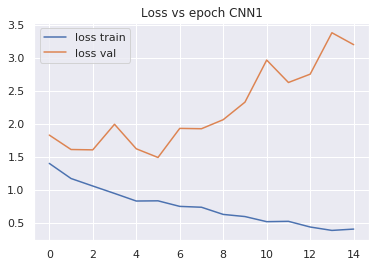

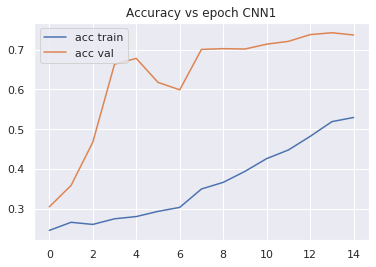


------ Training ------
Accuracy cnn1 : 0.6598682146219015
F1-score None cnn1 : [0.77169444 0.68531469 0.72727273 0.33343721]
F1-score macro cnn1 : 0.6294297647183914

------ Validation ------
Accuracy cnn1 : 0.7369411764705882
F1-score None cnn1 : [0.84247375 0.02439024 0.13636364 0.33908046]
F1-score macro cnn1 : 0.3355770214151153

------ Testing ------
Accuracy cnn1 : 0.7630711257654262
F1-score None cnn1 : [0.86836935 0.08333333 0.02564103 0.27628866]
F1-score macro cnn1 : 0.3134080926095286


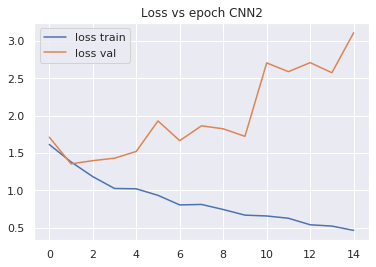

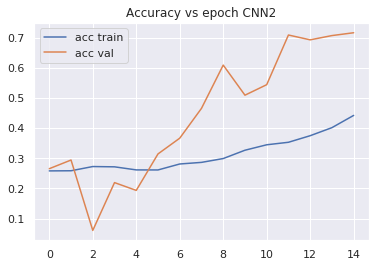


------ Training ------
Accuracy cnn2 : 0.6142139943520553
F1-score None cnn2 : [0.75018178 0.65671642 0.64179104 0.15212057]
F1-score macro cnn2 : 0.5502024544823354

------ Validation ------
Accuracy cnn2 : 0.7162352941176471
F1-score None cnn2 : [0.83243243 0.05       0.09090909 0.18003273]
F1-score macro cnn2 : 0.2883435641414365

------ Testing ------
Accuracy cnn2 : 0.7583608101742817
F1-score None cnn2 : [0.86264795 0.14516129 0.         0.16504854]
F1-score macro cnn2 : 0.29321444584126316


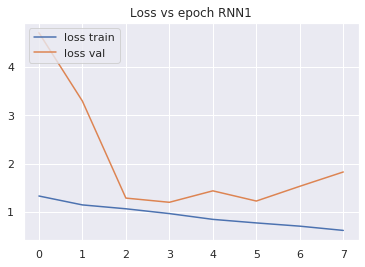

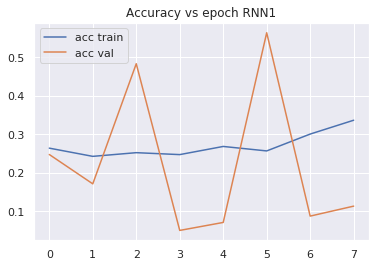


------ Training ------
Accuracy rnn1 : 0.18967681204894885
F1-score None rnn1 : [0.07281299 0.07380074 0.05505341 0.37074499]
F1-score macro rnn1 : 0.143103032593421

------ Validation ------
Accuracy rnn1 : 0.11341176470588235
F1-score None rnn1 : [0.04052288 0.12592593 0.04026846 0.24572317]
F1-score macro rnn1 : 0.11311010768676578

------ Testing ------
Accuracy rnn1 : 0.1125765426283561
F1-score None rnn1 : [0.01486068 0.20136054 0.10705596 0.20297952]
F1-score macro rnn1 : 0.1315641755578689


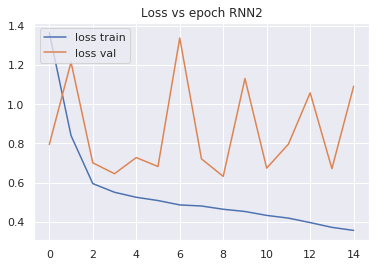

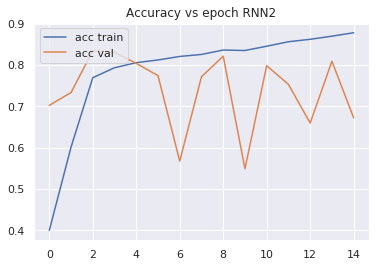


------ Training ------
Accuracy rnn2 : 0.8777847505491058
F1-score None rnn2 : [0.90207628 0.         0.         0.869207  ]
F1-score macro rnn2 : 0.44282082012890084

------ Validation ------
Accuracy rnn2 : 0.6724705882352942
F1-score None rnn2 : [0.76015625 0.         0.         0.57612129]
F1-score macro rnn2 : 0.3340693846730891

------ Testing ------
Accuracy rnn2 : 0.5996231747527084
F1-score None rnn2 : [0.72547529 0.         0.         0.44490934]
F1-score macro rnn2 : 0.29259615741550926


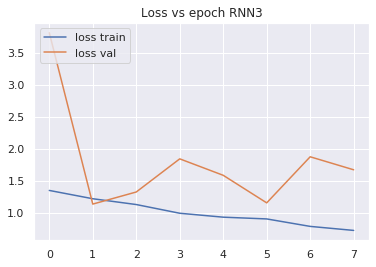

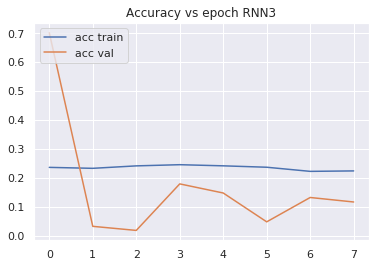


------ Training ------
Accuracy rnn3 : 0.15751490429871354
F1-score None rnn3 : [0.13760789 0.046107   0.05178702 0.32913472]
F1-score macro rnn3 : 0.14115915800346224

------ Validation ------
Accuracy rnn3 : 0.11623529411764706
F1-score None rnn3 : [0.09703844 0.07182941 0.03512195 0.32128514]
F1-score macro rnn3 : 0.13131873356189683

------ Testing ------
Accuracy rnn3 : 0.10692416391898257
F1-score None rnn3 : [0.08422301 0.0942285  0.08624898 0.26141079]
F1-score macro rnn3 : 0.13152782211645325

Entrenando exec  3 



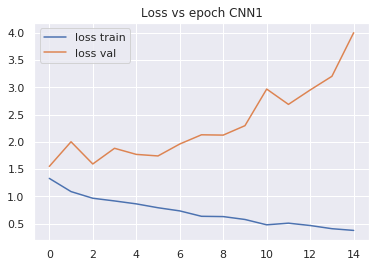

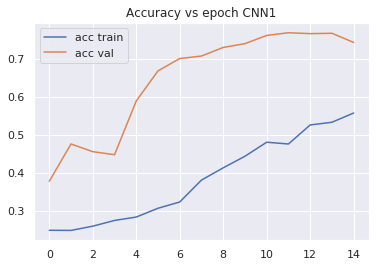


------ Training ------
Accuracy cnn1 : 0.7177596485723251
F1-score None cnn1 : [0.78794507 0.78461538 0.70175439 0.57942153]
F1-score macro cnn1 : 0.7134340924188767

------ Validation ------
Accuracy cnn1 : 0.7425882352941177
F1-score None cnn1 : [0.83644416 0.         0.13043478 0.52111226]
F1-score macro cnn1 : 0.37199780031374347

------ Testing ------
Accuracy cnn1 : 0.7479981158737635
F1-score None cnn1 : [0.85169492 0.03703704 0.05       0.46949602]
F1-score macro cnn1 : 0.35205699337785845


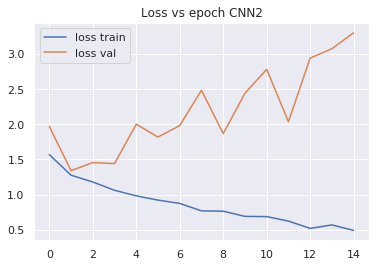

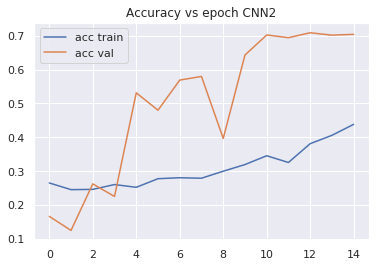


------ Training ------
Accuracy cnn2 : 0.6104486978349545
F1-score None cnn2 : [0.74671396 0.66666667 0.37037037 0.17579446]
F1-score macro cnn2 : 0.4898863626513905

------ Validation ------
Accuracy cnn2 : 0.704
F1-score None cnn2 : [0.82126437 0.         0.         0.20364742]
F1-score macro cnn2 : 0.2562279460573665

------ Testing ------
Accuracy cnn2 : 0.7404616109279322
F1-score None cnn2 : [0.84997211 0.01818182 0.02564103 0.19491525]
F1-score macro cnn2 : 0.27217755295898166


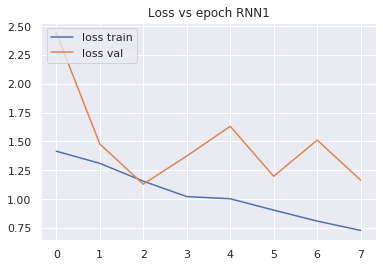

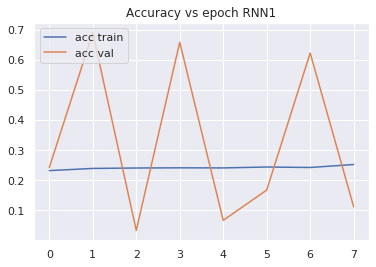


------ Training ------
Accuracy rnn1 : 0.15029808597427047
F1-score None rnn1 : [0.03794762 0.03047404 0.08580858 0.36752941]
F1-score macro rnn1 : 0.13043991371189426

------ Validation ------
Accuracy rnn1 : 0.112
F1-score None rnn1 : [0.02251656 0.08829713 0.04522613 0.32568306]
F1-score macro rnn1 : 0.12043071847336755

------ Testing ------
Accuracy rnn1 : 0.09043805934997645
F1-score None rnn1 : [0.00622665 0.11162791 0.14130435 0.23550725]
F1-score macro rnn1 : 0.1236665378104773


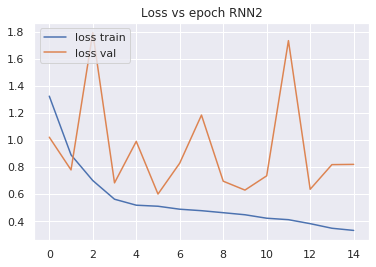

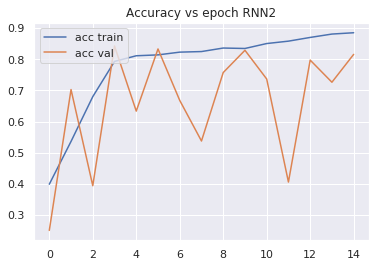


------ Training ------
Accuracy rnn2 : 0.9021022905553813
F1-score None rnn2 : [0.92547888 0.03174603 0.05128205 0.89067202]
F1-score macro rnn2 : 0.4747947440028537

------ Validation ------
Accuracy rnn2 : 0.8155294117647058
F1-score None rnn2 : [0.88625124 0.         0.         0.7009009 ]
F1-score macro rnn2 : 0.3967880343251263

------ Testing ------
Accuracy rnn2 : 0.7936881771078662
F1-score None rnn2 : [0.88654681 0.         0.02597403 0.60838323]
F1-score macro rnn2 : 0.3802260166746322


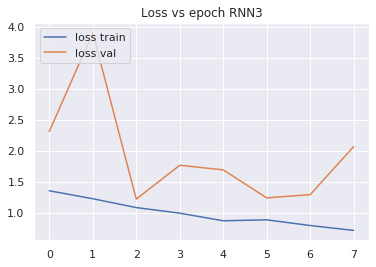

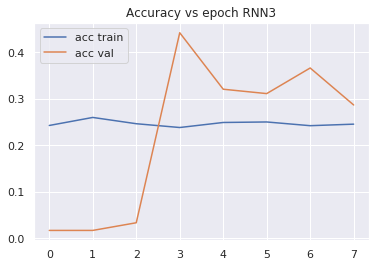


------ Training ------
Accuracy rnn3 : 0.3506432381550047
F1-score None rnn3 : [0.53968254 0.078125   0.04891097 0.30708899]
F1-score macro rnn3 : 0.24345187397007437

------ Validation ------
Accuracy rnn3 : 0.28658823529411764
F1-score None rnn3 : [0.44582339 0.0729927  0.04366079 0.30724638]
F1-score macro rnn3 : 0.21743081395393243

------ Testing ------
Accuracy rnn3 : 0.2110221384832784
F1-score None rnn3 : [0.30097586 0.02362205 0.07860825 0.36916836]
F1-score macro rnn3 : 0.19309362799066018

Entrenando exec  4 



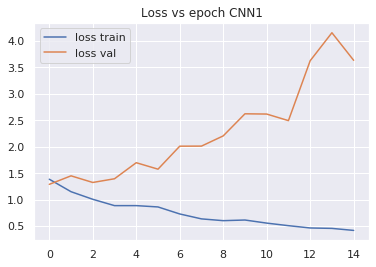

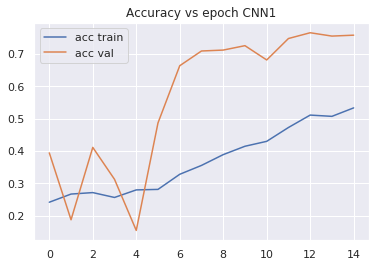


------ Training ------
Accuracy cnn1 : 0.6950109821148416
F1-score None cnn1 : [0.78863432 0.69064748 0.71345029 0.45840407]
F1-score macro cnn1 : 0.6627840426920313

------ Validation ------
Accuracy cnn1 : 0.7585882352941177
F1-score None cnn1 : [0.85362188 0.05263158 0.08888889 0.46882793]
F1-score macro cnn1 : 0.36599256989645335

------ Testing ------
Accuracy cnn1 : 0.7819123881300047
F1-score None cnn1 : [0.87848319 0.07272727 0.025      0.43826087]
F1-score macro cnn1 : 0.35361783419420845


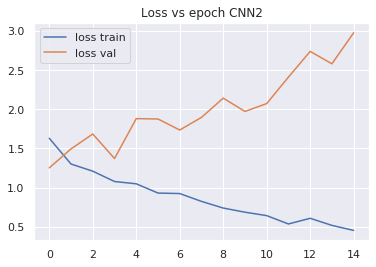

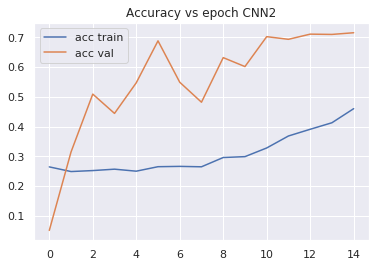


------ Training ------
Accuracy cnn2 : 0.6073109507373705
F1-score None cnn2 : [0.74682368 0.66086957 0.57894737 0.1303735 ]
F1-score macro cnn2 : 0.5292535278362827

------ Validation ------
Accuracy cnn2 : 0.715764705882353
F1-score None cnn2 : [0.83173889 0.02631579 0.1025641  0.13769363]
F1-score macro cnn2 : 0.2745781023674608

------ Testing ------
Accuracy cnn2 : 0.7555346208195949
F1-score None cnn2 : [0.8627451  0.05263158 0.02564103 0.08376963]
F1-score macro cnn2 : 0.25619683403386584


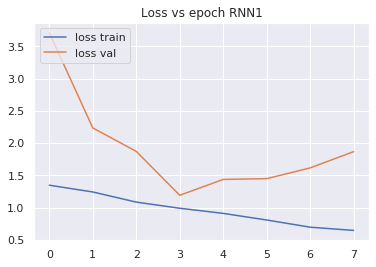

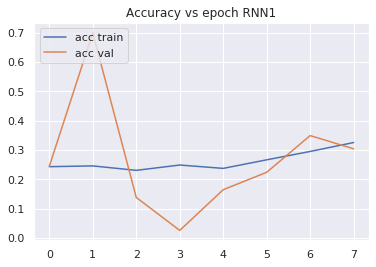


------ Training ------
Accuracy rnn1 : 0.432224662692187
F1-score None rnn1 : [0.4321773  0.06575342 0.11950395 0.579233  ]
F1-score macro rnn1 : 0.29916691742753443

------ Validation ------
Accuracy rnn1 : 0.3035294117647059
F1-score None rnn1 : [0.31170272 0.06481481 0.03759398 0.44096543]
F1-score macro rnn1 : 0.21376923618418808

------ Testing ------
Accuracy rnn1 : 0.25906735751295334
F1-score None rnn1 : [0.25704989 0.13618158 0.13286713 0.35552304]
F1-score macro rnn1 : 0.22040541075034492


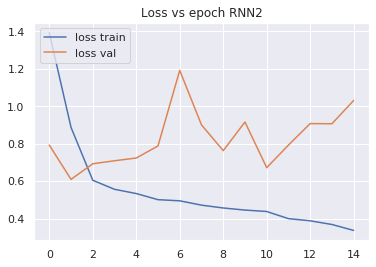

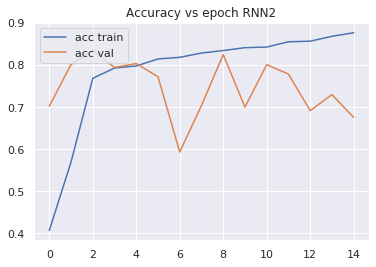


------ Training ------
Accuracy rnn2 : 0.866018198933166
F1-score None rnn2 : [0.88645448 0.24       0.36538462 0.85930513]
F1-score macro rnn2 : 0.5877860547769833

------ Validation ------
Accuracy rnn2 : 0.6757647058823529
F1-score None rnn2 : [0.76059655 0.05333333 0.         0.58490566]
F1-score macro rnn2 : 0.349708885005381

------ Testing ------
Accuracy rnn2 : 0.6057465850211964
F1-score None rnn2 : [0.72817008 0.01785714 0.07407407 0.45525018]
F1-score macro rnn2 : 0.31883786915869605


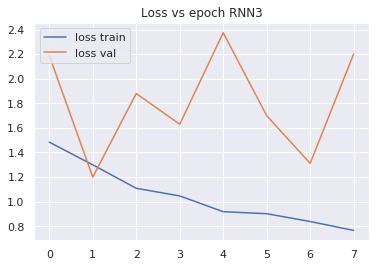

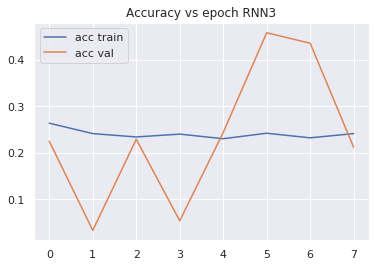


------ Training ------
Accuracy rnn3 : 0.25368685283966114
F1-score None rnn3 : [0.39170156 0.08024691 0.04048338 0.27997738]
F1-score macro rnn3 : 0.1981023083868259

------ Validation ------
Accuracy rnn3 : 0.21176470588235294
F1-score None rnn3 : [0.32200732 0.07692308 0.04454685 0.25392987]
F1-score macro rnn3 : 0.1743517783147006

------ Testing ------
Accuracy rnn3 : 0.17522373999057936
F1-score None rnn3 : [0.2344245  0.03883495 0.0880102  0.26643599]
F1-score macro rnn3 : 0.15692641002829089

Entrenando exec  5 



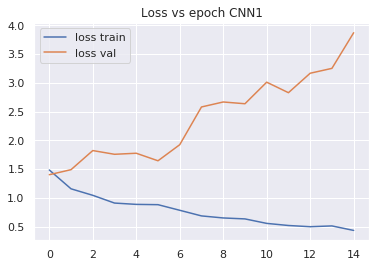

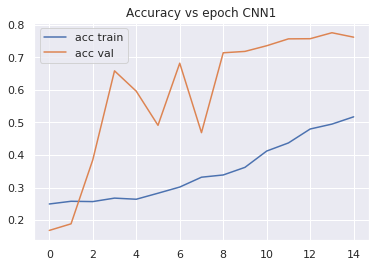


------ Training ------
Accuracy cnn1 : 0.6945403200502039
F1-score None cnn1 : [0.79469448 0.70229008 0.4874552  0.45948251]
F1-score macro cnn1 : 0.6109805665145818

------ Validation ------
Accuracy cnn1 : 0.7623529411764706
F1-score None cnn1 : [0.86154776 0.05263158 0.12987013 0.4765526 ]
F1-score macro cnn1 : 0.3801505175104728

------ Testing ------
Accuracy cnn1 : 0.7757889778615167
F1-score None cnn1 : [0.8783008  0.0862069  0.12631579 0.38475499]
F1-score macro cnn1 : 0.36889462015623403


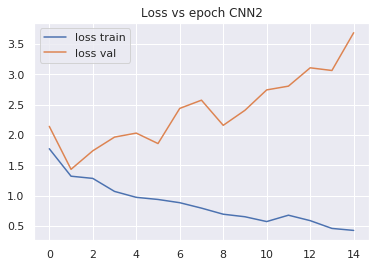

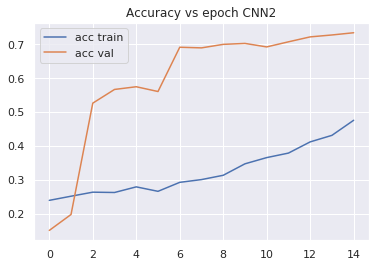


------ Training ------
Accuracy cnn2 : 0.653906495136492
F1-score None cnn2 : [0.76976467 0.74576271 0.47560976 0.33035439]
F1-score macro cnn2 : 0.5803728817349646

------ Validation ------
Accuracy cnn2 : 0.7345882352941177
F1-score None cnn2 : [0.84244373 0.02631579 0.03921569 0.33618234]
F1-score macro cnn2 : 0.31103938545851684

------ Testing ------
Accuracy cnn2 : 0.7555346208195949
F1-score None cnn2 : [0.86293273 0.01834862 0.025      0.27380952]
F1-score macro cnn2 : 0.29502272014112696


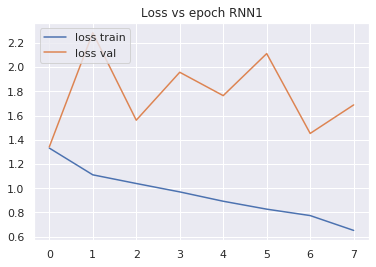

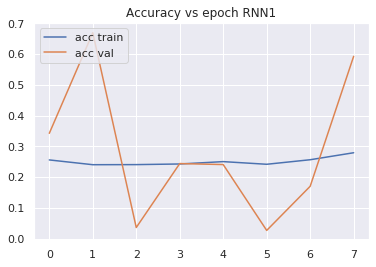


------ Training ------
Accuracy rnn1 : 0.4968622529024161
F1-score None rnn1 : [0.71759089 0.10479042 0.10782609 0.10068816]
F1-score macro rnn1 : 0.2577238887453344

------ Validation ------
Accuracy rnn1 : 0.5924705882352941
F1-score None rnn1 : [0.78451951 0.15231788 0.05504587 0.10839161]
F1-score macro rnn1 : 0.27506871883522316

------ Testing ------
Accuracy rnn1 : 0.6406029203956665
F1-score None rnn1 : [0.80567193 0.26521739 0.17449664 0.11948052]
F1-score macro rnn1 : 0.34121662136752867


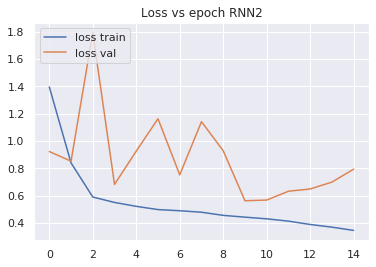

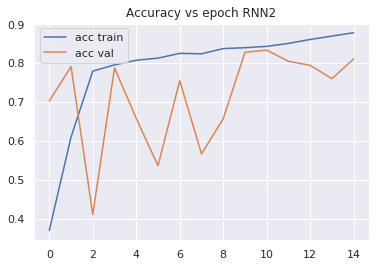


------ Training ------
Accuracy rnn2 : 0.818951992469407
F1-score None rnn2 : [0.86707566 0.         0.19847328 0.75506359]
F1-score macro rnn2 : 0.4551531340812264

------ Validation ------
Accuracy rnn2 : 0.8108235294117647
F1-score None rnn2 : [0.88530688 0.         0.         0.6519337 ]
F1-score macro rnn2 : 0.38431014581114087

------ Testing ------
Accuracy rnn2 : 0.8167687235044748
F1-score None rnn2 : [0.89393939 0.         0.18181818 0.61935484]
F1-score macro rnn2 : 0.4237781036168133


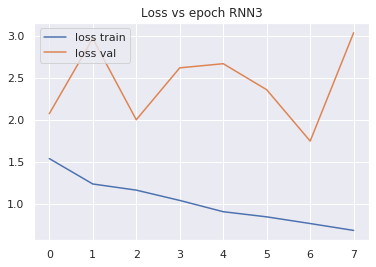

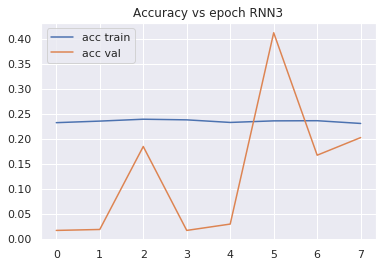


------ Training ------
Accuracy rnn3 : 0.3065578914339504
F1-score None rnn3 : [0.13939694 0.11802233 0.06345733 0.50488234]
F1-score macro rnn3 : 0.20643973443349434

------ Validation ------
Accuracy rnn3 : 0.2028235294117647
F1-score None rnn3 : [0.11552795 0.08730159 0.04483188 0.38990536]
F1-score macro rnn3 : 0.1593916952091226

------ Testing ------
Accuracy rnn3 : 0.1521431935939708
F1-score None rnn3 : [0.09976526 0.09561753 0.08275862 0.31476569]
F1-score macro rnn3 : 0.14822677571553364


In [15]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=15, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=15, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=15, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [16]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("Original - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("Original - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("Original - Accuracy promedio para",key,":" ,temp/5)

Original - F1-score promedio para cnn1 : [0.85668979 0.06306812 0.05051957 0.40412038]
Original - F1-score promedio para cnn2 : [0.85489733 0.0792176  0.04602564 0.19636144]
Original - F1-score promedio para rnn1 : [0.36928469 0.17848249 0.12595963 0.24450064]
Original - F1-score promedio para rnn2 : [0.8079784  0.04148612 0.08013563 0.53303122]
Original - F1-score promedio para rnn3 : [0.15145719 0.06937953 0.08724355 0.30415019]

Original - F1-score macro promedio para cnn1 : 0.34359946231440774 desvest:  0.019532892420450382
Original - F1-score macro promedio para cnn2 : 0.294125504726757 desvest:  0.03319276903378188
Original - F1-score macro promedio para rnn1 : 0.22955686284389648 desvest:  0.09342784321641193
Original - F1-score macro promedio para rnn2 : 0.36565784438110205 desvest:  0.0516672379360382
Original - F1-score macro promedio para rnn3 : 0.15305761320779496 desvest:  0.021965961493530417

Original - Accuracy promedio para cnn1 : 0.751012717852096
Original - Accuracy 

### Aumento no Ponderado - Clase

In [17]:
macro_augmented = np.load('../Datasets/CSV_Harassment/balance_clase_noPon.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



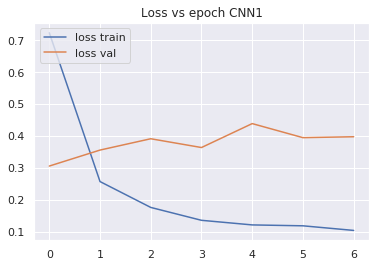

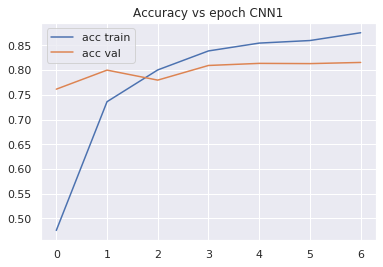


------ Training ------
Accuracy cnn1 : 0.8989347172903578
F1-score None cnn1 : [0.82391622 0.99672489 0.99287671 0.77698511]
F1-score macro cnn1 : 0.8976257337466509

------ Validation ------
Accuracy cnn1 : 0.8155294117647058
F1-score None cnn1 : [0.8877551  0.         0.09756098 0.67732268]
F1-score macro cnn1 : 0.41565968874331244

------ Testing ------
Accuracy cnn1 : 0.8172397550635893
F1-score None cnn1 : [0.89797154 0.         0.02597403 0.66139657]
F1-score macro cnn1 : 0.3963355353593477


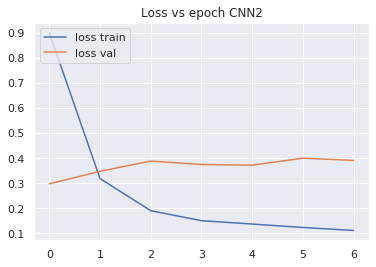

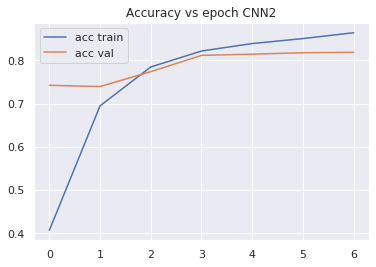


------ Training ------
Accuracy cnn2 : 0.9065829008467632
F1-score None cnn2 : [0.83521611 0.99727149 0.99631399 0.79241794]
F1-score macro cnn2 : 0.9053048820705693

------ Validation ------
Accuracy cnn2 : 0.8183529411764706
F1-score None cnn2 : [0.88824289 0.         0.09756098 0.69548511]
F1-score macro cnn2 : 0.42032224503432625

------ Testing ------
Accuracy cnn2 : 0.8002826189354687
F1-score None cnn2 : [0.88781665 0.01834862 0.02597403 0.60483871]
F1-score macro cnn2 : 0.38424450151669487


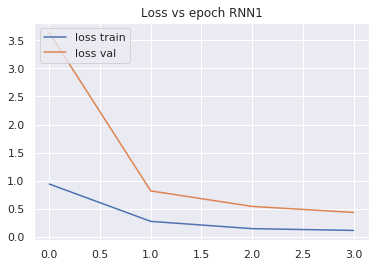

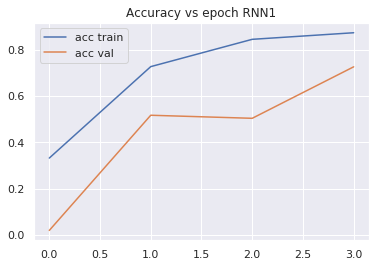


------ Training ------
Accuracy rnn1 : 0.8972275334608031
F1-score None rnn1 : [0.81201741 0.98662299 0.98180816 0.80996967]
F1-score macro rnn1 : 0.8976045556949812

------ Validation ------
Accuracy rnn1 : 0.7256470588235294
F1-score None rnn1 : [0.81787957 0.04040404 0.0754717  0.61969806]
F1-score macro rnn1 : 0.388363342237247

------ Testing ------
Accuracy rnn1 : 0.6660386245878473
F1-score None rnn1 : [0.78741866 0.14765101 0.13333333 0.50081566]
F1-score macro rnn1 : 0.3923046639568779


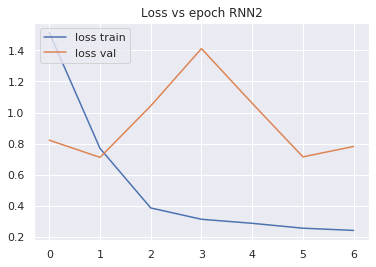

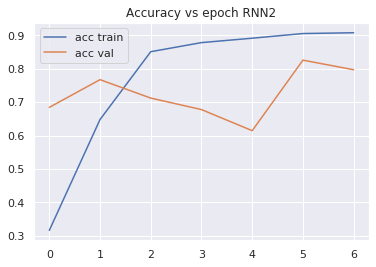


------ Training ------
Accuracy rnn2 : 0.9178503141218246
F1-score None rnn2 : [0.85046373 0.9954998  0.9954998  0.82772923]
F1-score macro rnn2 : 0.9172981359495311

------ Validation ------
Accuracy rnn2 : 0.7967058823529412
F1-score None rnn2 : [0.87411407 0.02469136 0.03846154 0.68630849]
F1-score macro rnn2 : 0.40589386556533746

------ Testing ------
Accuracy rnn2 : 0.7640131888836552
F1-score None rnn2 : [0.8627451  0.01724138 0.12903226 0.60388946]
F1-score macro rnn2 : 0.4032270482342766


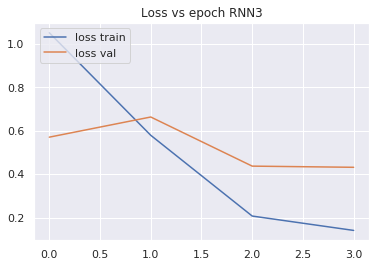

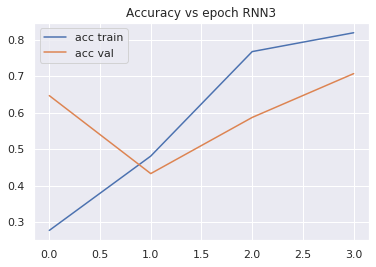


------ Training ------
Accuracy rnn3 : 0.8082491122644087
F1-score None rnn3 : [0.73439205 0.91188218 0.93243622 0.62039708]
F1-score macro rnn3 : 0.7997768816131551

------ Validation ------
Accuracy rnn3 : 0.7068235294117647
F1-score None rnn3 : [0.82262383 0.10810811 0.09090909 0.53991597]
F1-score macro rnn3 : 0.3903892485129197

------ Testing ------
Accuracy rnn3 : 0.6966556759302873
F1-score None rnn3 : [0.81430446 0.19937695 0.14814815 0.51495449]
F1-score macro rnn3 : 0.4191960108692019

Entrenando exec  2 



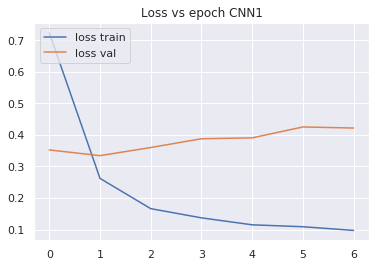

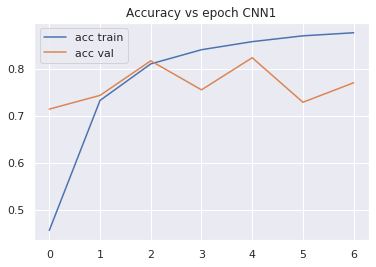


------ Training ------
Accuracy cnn1 : 0.9309614859328053
F1-score None cnn1 : [0.86443249 0.99632203 0.99672131 0.86605206]
F1-score macro cnn1 : 0.9308819728136997

------ Validation ------
Accuracy cnn1 : 0.7698823529411765
F1-score None cnn1 : [0.85046067 0.         0.1        0.66007605]
F1-score macro cnn1 : 0.40263417795539125

------ Testing ------
Accuracy cnn1 : 0.7253886010362695
F1-score None cnn1 : [0.83840109 0.         0.         0.55105634]
F1-score macro cnn1 : 0.3473643578244321


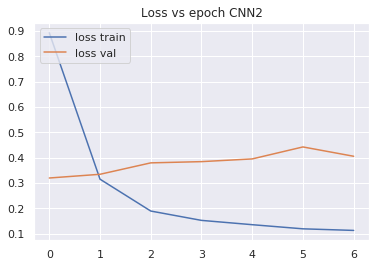

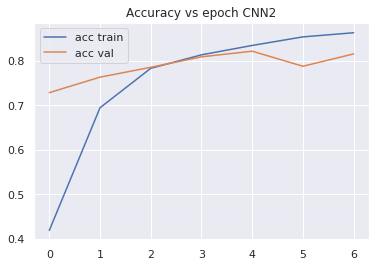


------ Training ------
Accuracy cnn2 : 0.9052171537831194
F1-score None cnn2 : [0.83349633 0.99631399 0.9964568  0.78882855]
F1-score macro cnn2 : 0.9037739187933591

------ Validation ------
Accuracy cnn2 : 0.8155294117647058
F1-score None cnn2 : [0.88932292 0.         0.09756098 0.68544601]
F1-score macro cnn2 : 0.41808247541652355

------ Testing ------
Accuracy cnn2 : 0.8031088082901554
F1-score None cnn2 : [0.89137877 0.         0.02597403 0.64075383]
F1-score macro cnn2 : 0.38952665693468025


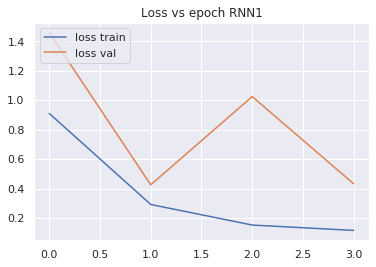

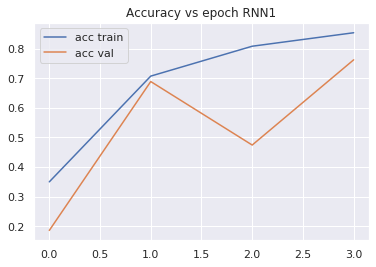


------ Training ------
Accuracy rnn1 : 0.8783119366293363
F1-score None rnn1 : [0.80059124 0.98302344 0.95635128 0.76077968]
F1-score macro rnn1 : 0.8751864111201134

------ Validation ------
Accuracy rnn1 : 0.7623529411764706
F1-score None rnn1 : [0.86172065 0.06837607 0.13636364 0.65486726]
F1-score macro rnn1 : 0.430331904050244

------ Testing ------
Accuracy rnn1 : 0.7103155911446067
F1-score None rnn1 : [0.83412969 0.15568862 0.17475728 0.54082715]
F1-score macro rnn1 : 0.4263506861356406


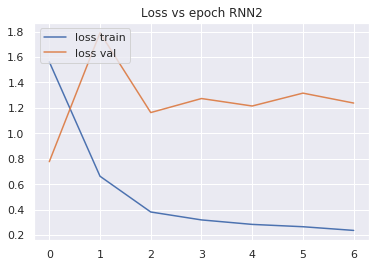

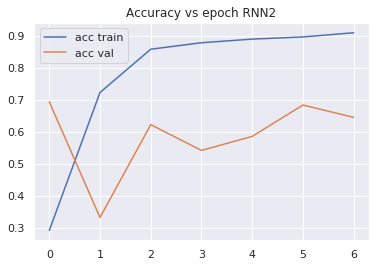


------ Training ------
Accuracy rnn2 : 0.9186014750068288
F1-score None rnn2 : [0.84529554 0.99384489 0.9740588  0.85717936]
F1-score macro rnn2 : 0.9175946460654143

------ Validation ------
Accuracy rnn2 : 0.6456470588235295
F1-score None rnn2 : [0.74669868 0.         0.10810811 0.56487549]
F1-score macro rnn2 : 0.35492056976522324

------ Testing ------
Accuracy rnn2 : 0.5793688177107866
F1-score None rnn2 : [0.70693687 0.0483871  0.15053763 0.44671533]
F1-score macro rnn2 : 0.3381442315921443


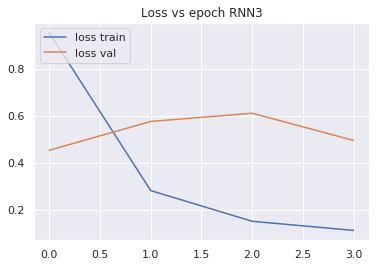

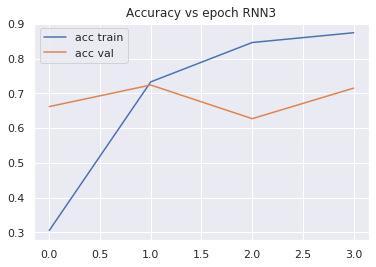


------ Training ------
Accuracy rnn3 : 0.8814531548757171
F1-score None rnn3 : [0.80873094 0.96341142 0.96038825 0.77959243]
F1-score macro rnn3 : 0.8780307586015836

------ Validation ------
Accuracy rnn3 : 0.7152941176470589
F1-score None rnn3 : [0.82619832 0.11392405 0.05633803 0.62119967]
F1-score macro rnn3 : 0.40441501674819036

------ Testing ------
Accuracy rnn3 : 0.6919453603391427
F1-score None rnn3 : [0.81353542 0.18994413 0.18181818 0.5314554 ]
F1-score macro rnn3 : 0.4291882849254688

Entrenando exec  3 



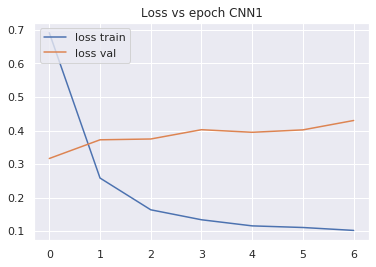

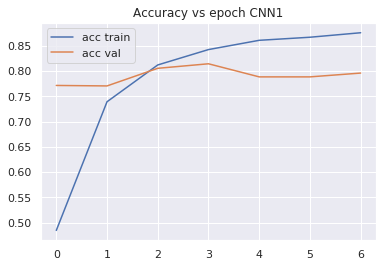


------ Training ------
Accuracy cnn1 : 0.9211281070745698
F1-score None cnn1 : [0.85119831 0.99644906 0.99686691 0.83914095]
F1-score macro cnn1 : 0.9209138077979644

------ Validation ------
Accuracy cnn1 : 0.7957647058823529
F1-score None cnn1 : [0.87461774 0.         0.05       0.67447699]
F1-score macro cnn1 : 0.39977368111268924

------ Testing ------
Accuracy cnn1 : 0.7677814413565709
F1-score None cnn1 : [0.86931079 0.         0.02597403 0.59229209]
F1-score macro cnn1 : 0.37189422711537257


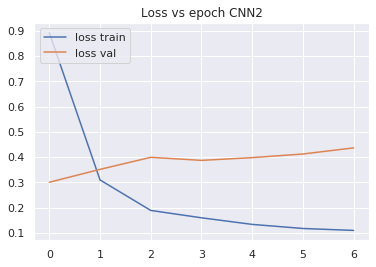

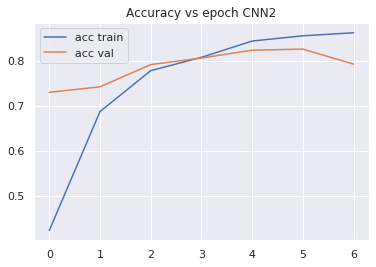


------ Training ------
Accuracy cnn2 : 0.9222207047254848
F1-score None cnn2 : [0.85352526 0.99438894 0.99686691 0.84377189]
F1-score macro cnn2 : 0.9221382508728588

------ Validation ------
Accuracy cnn2 : 0.7929411764705883
F1-score None cnn2 : [0.87033869 0.         0.09756098 0.67710049]
F1-score macro cnn2 : 0.41125004074179916

------ Testing ------
Accuracy cnn2 : 0.7790861987753179
F1-score None cnn2 : [0.87880752 0.         0.02564103 0.60860656]
F1-score macro cnn2 : 0.37826377521012466


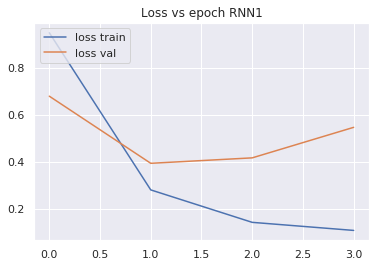

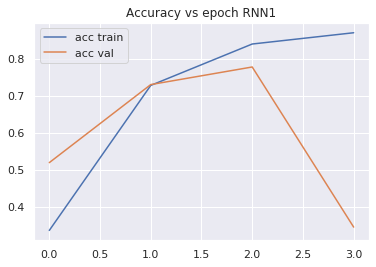


------ Training ------
Accuracy rnn1 : 0.7398251843758535
F1-score None rnn1 : [0.43368421 0.92760379 0.9027342  0.65555556]
F1-score macro rnn1 : 0.7298944383298116

------ Validation ------
Accuracy rnn1 : 0.34494117647058825
F1-score None rnn1 : [0.25694444 0.         0.08888889 0.42558528]
F1-score macro rnn1 : 0.19285465440356744

------ Testing ------
Accuracy rnn1 : 0.23316062176165803
F1-score None rnn1 : [0.17123288 0.05128205 0.04651163 0.29681362]
F1-score macro rnn1 : 0.1414600436021397


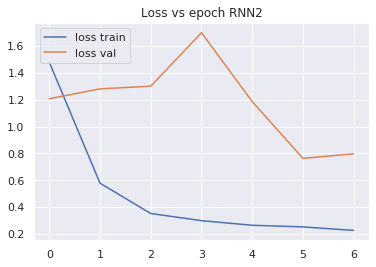

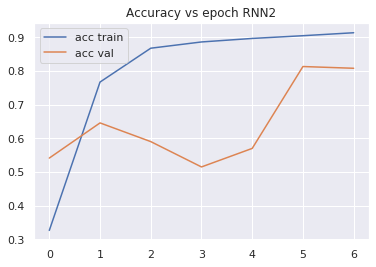


------ Training ------
Accuracy rnn2 : 0.9179186014750068
F1-score None rnn2 : [0.855455   0.98703806 0.99494881 0.83375278]
F1-score macro rnn2 : 0.9177986605407237

------ Validation ------
Accuracy rnn2 : 0.8084705882352942
F1-score None rnn2 : [0.8861518  0.02597403 0.06349206 0.69439421]
F1-score macro rnn2 : 0.41750302511271015

------ Testing ------
Accuracy rnn2 : 0.7847385774846914
F1-score None rnn2 : [0.8778481  0.         0.15238095 0.62442396]
F1-score macro rnn2 : 0.4136632541951039


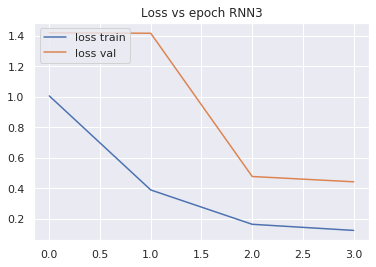

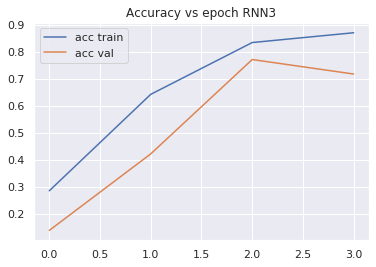


------ Training ------
Accuracy rnn3 : 0.9044659928981152
F1-score None rnn3 : [0.81613833 0.99194979 0.98509096 0.82433835]
F1-score macro rnn3 : 0.9043793564093225

------ Validation ------
Accuracy rnn3 : 0.7176470588235294
F1-score None rnn3 : [0.80828625 0.04651163 0.05       0.6270119 ]
F1-score macro rnn3 : 0.3829524441730241

------ Testing ------
Accuracy rnn3 : 0.6542628356099859
F1-score None rnn3 : [0.77810219 0.07692308 0.10344828 0.4952381 ]
F1-score macro rnn3 : 0.36342790945106573

Entrenando exec  4 



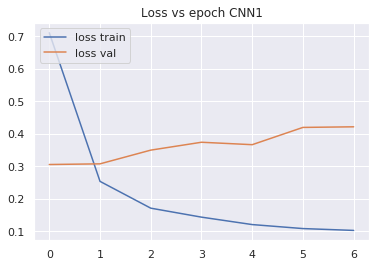

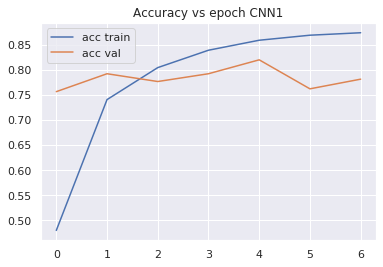


------ Training ------
Accuracy cnn1 : 0.9237913138486752
F1-score None cnn1 : [0.85608759 0.99604743 0.99754768 0.84438122]
F1-score macro cnn1 : 0.923515981367966

------ Validation ------
Accuracy cnn1 : 0.7816470588235294
F1-score None cnn1 : [0.86373021 0.         0.14285714 0.65581774]
F1-score macro cnn1 : 0.41560127355180043

------ Testing ------
Accuracy cnn1 : 0.7362223268959021
F1-score None cnn1 : [0.84566455 0.         0.05128205 0.5544186 ]
F1-score macro cnn1 : 0.36284130057520175


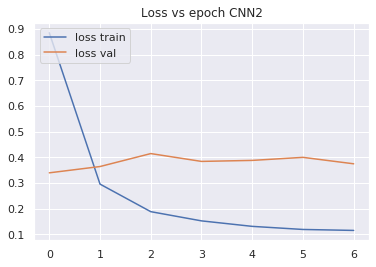

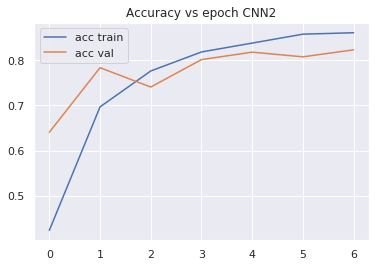


------ Training ------
Accuracy cnn2 : 0.9035782573067468
F1-score None cnn2 : [0.83280526 0.99509537 0.99494328 0.78536965]
F1-score macro cnn2 : 0.9020533912149182

------ Validation ------
Accuracy cnn2 : 0.8230588235294117
F1-score None cnn2 : [0.89435046 0.02702703 0.05       0.68993021]
F1-score macro cnn2 : 0.41532692480352607

------ Testing ------
Accuracy cnn2 : 0.8304286387187941
F1-score None cnn2 : [0.90777139 0.03636364 0.02597403 0.68882979]
F1-score macro cnn2 : 0.4147347108961013


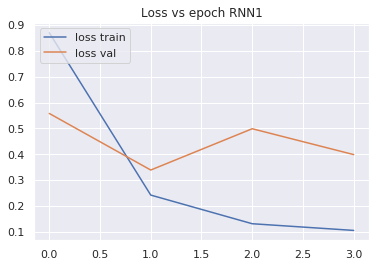

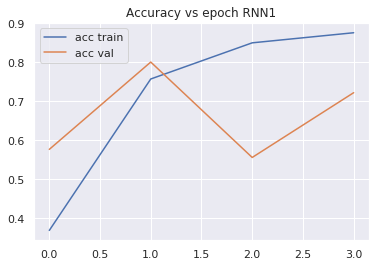


------ Training ------
Accuracy rnn1 : 0.9073340617317672
F1-score None rnn1 : [0.82147351 0.9911287  0.99153237 0.82500668]
F1-score macro rnn1 : 0.907285314254961

------ Validation ------
Accuracy rnn1 : 0.7223529411764706
F1-score None rnn1 : [0.8121031  0.08510638 0.125      0.6163522 ]
F1-score macro rnn1 : 0.4096404211805508

------ Testing ------
Accuracy rnn1 : 0.6632124352331606
F1-score None rnn1 : [0.78371501 0.11594203 0.10752688 0.50158228]
F1-score macro rnn1 : 0.37719155047739905


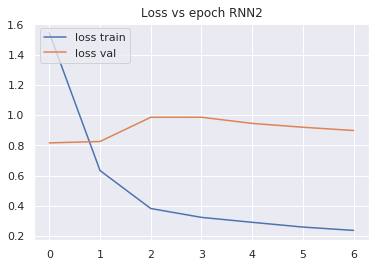

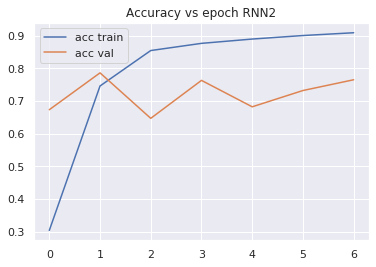


------ Training ------
Accuracy rnn2 : 0.934444140945097
F1-score None rnn2 : [0.88116174 0.99496393 0.99093001 0.86889898]
F1-score macro rnn2 : 0.9339886646875353

------ Validation ------
Accuracy rnn2 : 0.7651764705882353
F1-score None rnn2 : [0.85494582 0.07594937 0.05405405 0.64401294]
F1-score macro rnn2 : 0.40724054731631076

------ Testing ------
Accuracy rnn2 : 0.7409326424870466
F1-score None rnn2 : [0.84708249 0.08       0.125      0.58033106]
F1-score macro rnn2 : 0.4081033890783846


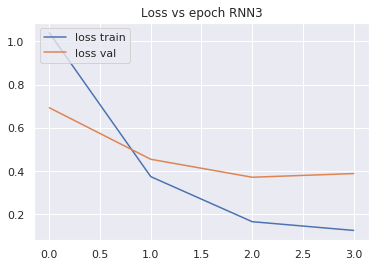

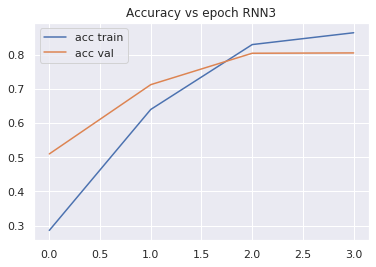


------ Training ------
Accuracy rnn3 : 0.82450150232177
F1-score None rnn3 : [0.76224881 0.95011691 0.90606421 0.66389074]
F1-score macro rnn3 : 0.8205801692241331

------ Validation ------
Accuracy rnn3 : 0.8047058823529412
F1-score None rnn3 : [0.88363171 0.12048193 0.         0.69584245]
F1-score macro rnn3 : 0.42498902300792374

------ Testing ------
Accuracy rnn3 : 0.8040508714083844
F1-score None rnn3 : [0.88861912 0.21487603 0.04819277 0.68690096]
F1-score macro rnn3 : 0.4596472206218115

Entrenando exec  5 



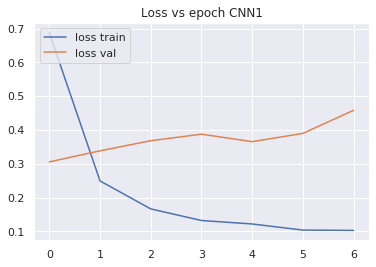

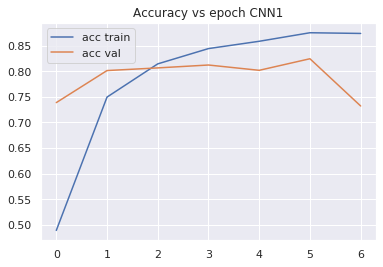


------ Training ------
Accuracy cnn1 : 0.9288445779841573
F1-score None cnn1 : [0.8580478  0.99617695 0.99328859 0.8676947 ]
F1-score macro cnn1 : 0.9288020100988431

------ Validation ------
Accuracy cnn1 : 0.7322352941176471
F1-score None cnn1 : [0.81858736 0.         0.09756098 0.62612301]
F1-score macro cnn1 : 0.38556783733379163

------ Testing ------
Accuracy cnn1 : 0.6504945831370702
F1-score None cnn1 : [0.77489967 0.         0.02597403 0.48181818]
F1-score macro cnn1 : 0.3206729698612223


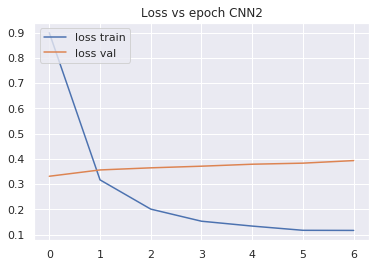

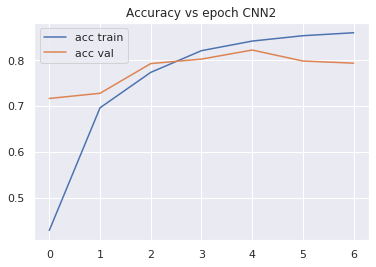


------ Training ------
Accuracy cnn2 : 0.8973641081671675
F1-score None cnn2 : [0.81206082 0.9965861  0.99713857 0.78099721]
F1-score macro cnn2 : 0.8966956734824231

------ Validation ------
Accuracy cnn2 : 0.7938823529411765
F1-score None cnn2 : [0.86950732 0.02739726 0.09756098 0.66784452]
F1-score macro cnn2 : 0.41557752060512543

------ Testing ------
Accuracy cnn2 : 0.7701365991521432
F1-score None cnn2 : [0.86786503 0.         0.05       0.57817773]
F1-score macro cnn2 : 0.37401068864736287


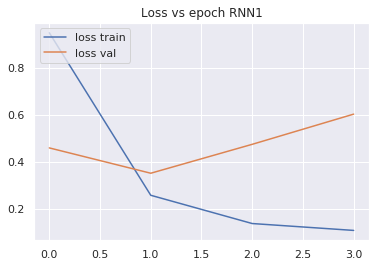

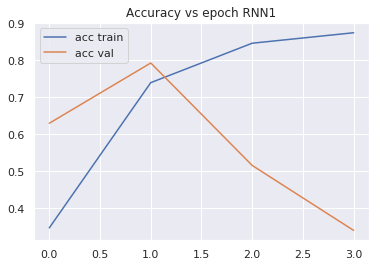


------ Training ------
Accuracy rnn1 : 0.8066785031412183
F1-score None rnn1 : [0.44477172 0.96557182 0.98661202 0.72347934]
F1-score macro rnn1 : 0.7801087283169459

------ Validation ------
Accuracy rnn1 : 0.3402352941176471
F1-score None rnn1 : [0.26743516 0.05       0.10344828 0.42141924]
F1-score macro rnn1 : 0.21057566921342863

------ Testing ------
Accuracy rnn1 : 0.24022609514837495
F1-score None rnn1 : [0.18057922 0.1826484  0.15652174 0.29939563]
F1-score macro rnn1 : 0.20478624681270646


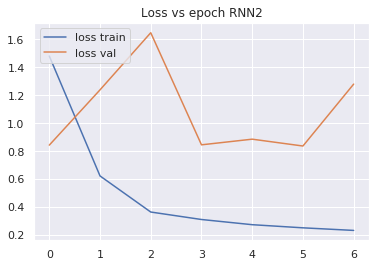

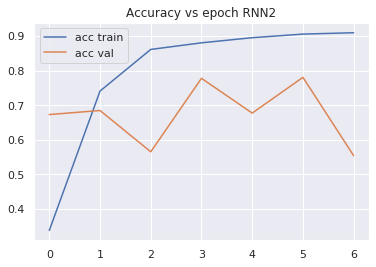


------ Training ------
Accuracy rnn2 : 0.8969543840480743
F1-score None rnn2 : [0.79218074 0.99524133 0.95550046 0.83248225]
F1-score macro rnn2 : 0.8938511953175435

------ Validation ------
Accuracy rnn2 : 0.5538823529411765
F1-score None rnn2 : [0.63829787 0.04255319 0.06134969 0.51813472]
F1-score macro rnn2 : 0.31508386802680693

------ Testing ------
Accuracy rnn2 : 0.4338200659444183
F1-score None rnn2 : [0.53859964 0.05970149 0.14166667 0.3649635 ]
F1-score macro rnn2 : 0.27623282594679693


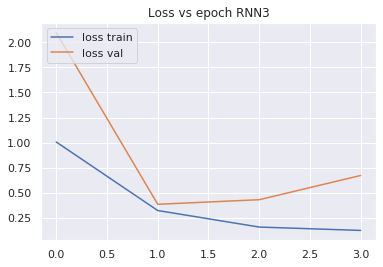

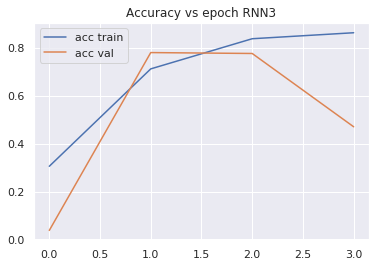


------ Training ------
Accuracy rnn3 : 0.85816716744059
F1-score None rnn3 : [0.69591733 0.98013956 0.95400651 0.77500605]
F1-score macro rnn3 : 0.8512673648533968

------ Validation ------
Accuracy rnn3 : 0.47011764705882353
F1-score None rnn3 : [0.52839269 0.06944444 0.10989011 0.47128927]
F1-score macro rnn3 : 0.29475412842875803

------ Testing ------
Accuracy rnn3 : 0.37070183702308057
F1-score None rnn3 : [0.43266894 0.15730337 0.15322581 0.35053885]
F1-score macro rnn3 : 0.27343424170165337


In [18]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [19]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase - Accuracy promedio para",key,":" ,temp/5)

0.15 Clase - F1-score promedio para cnn1 : [0.84524953 0.         0.02584083 0.56819636]
0.15 Clase - F1-score promedio para cnn2 : [0.88672787 0.01094245 0.03071262 0.62424132]
0.15 Clase - F1-score promedio para rnn1 : [0.55141509 0.13064242 0.12373017 0.42788687]
0.15 Clase - F1-score promedio para rnn2 : [0.76664244 0.04106599 0.1397235  0.52406466]
0.15 Clase - F1-score promedio para rnn3 : [0.74544603 0.16768471 0.12696664 0.51581756]

0.15 Clase - F1-score macro promedio para cnn1 : 0.35982167814711524 desvest:  0.02520290664502946
0.15 Clase - F1-score macro promedio para cnn2 : 0.3881560666409928 desvest:  0.014293721266698074
0.15 Clase - F1-score macro promedio para rnn1 : 0.30841863819695275 desvest:  0.11339258491227236
0.15 Clase - F1-score macro promedio para rnn2 : 0.3678741498093413 desvest:  0.05337951194258141
0.15 Clase - F1-score macro promedio para rnn3 : 0.38897873351384027 desvest:  0.0656160058888807

0.15 Clase - Accuracy promedio para cnn1 : 0.739425341497880

In [20]:
macro_augmented = np.load('../Datasets/CSV_Harassment/balance_clase_Pon.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



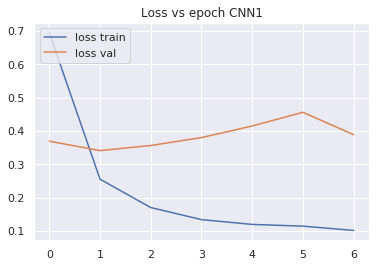

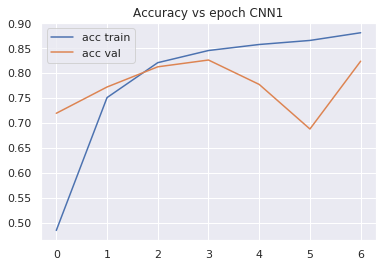


------ Training ------
Accuracy cnn1 : 0.897568970226714
F1-score None cnn1 : [0.82457191 0.99397425 0.99646162 0.76697948]
F1-score macro cnn1 : 0.8954968162162371

------ Validation ------
Accuracy cnn1 : 0.824
F1-score None cnn1 : [0.8947202  0.         0.09756098 0.68583162]
F1-score macro cnn1 : 0.4195282000314746

------ Testing ------
Accuracy cnn1 : 0.8271314178049929
F1-score None cnn1 : [0.90477603 0.         0.05063291 0.66376812]
F1-score macro cnn1 : 0.4047942645464534


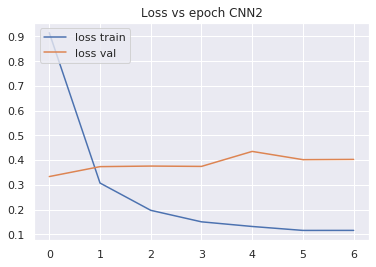

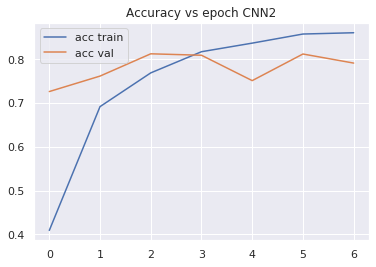


------ Training ------
Accuracy cnn2 : 0.916894291177274
F1-score None cnn2 : [0.84677842 0.99328491 0.99618529 0.83079116]
F1-score macro cnn2 : 0.9167599443817773

------ Validation ------
Accuracy cnn2 : 0.7910588235294118
F1-score None cnn2 : [0.8707483  0.         0.0952381  0.66722408]
F1-score macro cnn2 : 0.40830261870634543

------ Testing ------
Accuracy cnn2 : 0.7710786622703721
F1-score None cnn2 : [0.87106203 0.         0.05063291 0.59938838]
F1-score macro cnn2 : 0.38027083093123426


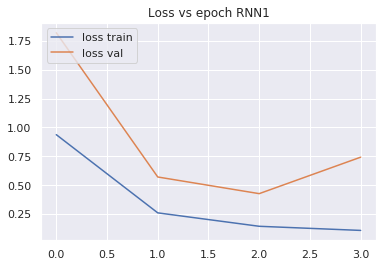

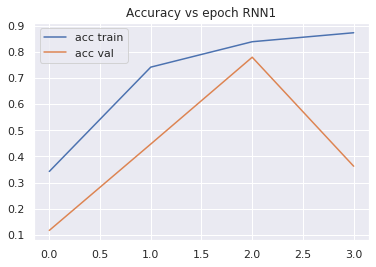


------ Training ------
Accuracy rnn1 : 0.809478284621688
F1-score None rnn1 : [0.49899071 0.91754386 0.9745774  0.74561701]
F1-score macro rnn1 : 0.7841822462620585

------ Validation ------
Accuracy rnn1 : 0.3623529411764706
F1-score None rnn1 : [0.32908587 0.10033445 0.09448819 0.44774641]
F1-score macro rnn1 : 0.24291372970662822

------ Testing ------
Accuracy rnn1 : 0.25529910504003767
F1-score None rnn1 : [0.2109375  0.20111732 0.17307692 0.31673729]
F1-score macro rnn1 : 0.2254672574120676


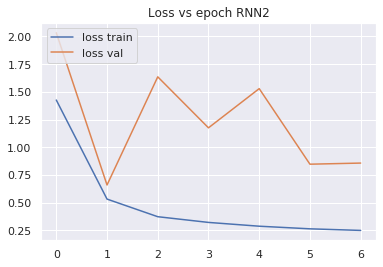

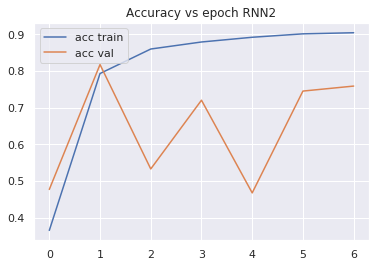


------ Training ------
Accuracy rnn2 : 0.9335564053537285
F1-score None rnn2 : [0.87631831 0.99093157 0.99344441 0.87423853]
F1-score macro rnn2 : 0.9337332071012797

------ Validation ------
Accuracy rnn2 : 0.7590588235294118
F1-score None rnn2 : [0.8418422  0.         0.03846154 0.65556397]
F1-score macro rnn2 : 0.3839669260920012

------ Testing ------
Accuracy rnn2 : 0.7150259067357513
F1-score None rnn2 : [0.82474227 0.0661157  0.15053763 0.54723708]
F1-score macro rnn2 : 0.39715817039450485


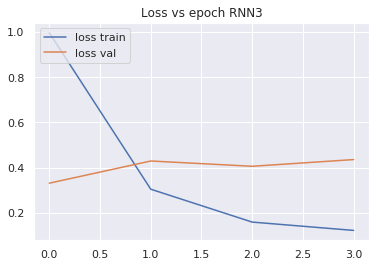

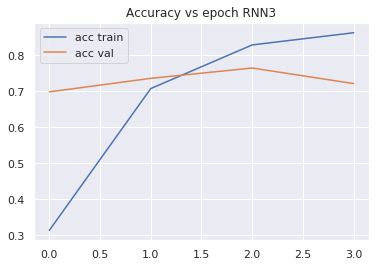


------ Training ------
Accuracy rnn3 : 0.8940180278612401
F1-score None rnn3 : [0.81505999 0.98333333 0.97569444 0.79504853]
F1-score macro rnn3 : 0.8922840748838525

------ Validation ------
Accuracy rnn3 : 0.7218823529411764
F1-score None rnn3 : [0.82206796 0.12844037 0.1        0.61682243]
F1-score macro rnn3 : 0.41683268862421224

------ Testing ------
Accuracy rnn3 : 0.6872350447479981
F1-score None rnn3 : [0.80608634 0.13017751 0.18421053 0.53685168]
F1-score macro rnn3 : 0.41433151639384397

Entrenando exec  2 



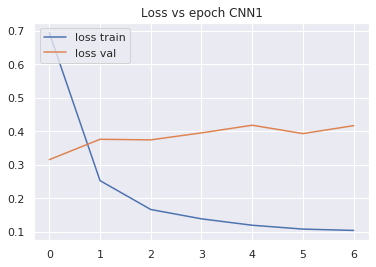

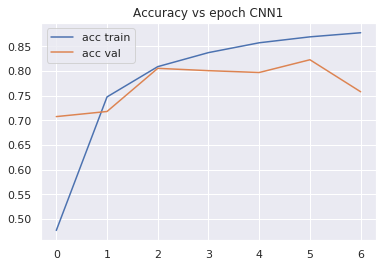


------ Training ------
Accuracy cnn1 : 0.9287080032777929
F1-score None cnn1 : [0.85698135 0.99618321 0.99713935 0.86370272]
F1-score macro cnn1 : 0.9285016566120441

------ Validation ------
Accuracy cnn1 : 0.7581176470588236
F1-score None cnn1 : [0.84073673 0.         0.09756098 0.6505848 ]
F1-score macro cnn1 : 0.3972206247480162

------ Testing ------
Accuracy cnn1 : 0.7192651907677814
F1-score None cnn1 : [0.83264463 0.         0.02597403 0.54749568]
F1-score macro cnn1 : 0.3515285840709769


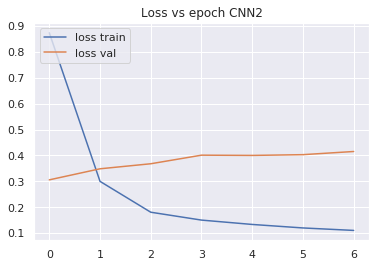

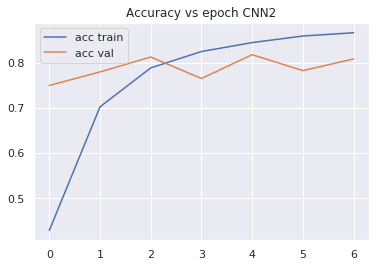


------ Training ------
Accuracy cnn2 : 0.923723026495493
F1-score None cnn2 : [0.8588174  0.99562483 0.9964568  0.84305835]
F1-score macro cnn2 : 0.9234893449445529

------ Validation ------
Accuracy cnn2 : 0.8084705882352942
F1-score None cnn2 : [0.88209607 0.         0.09756098 0.69482759]
F1-score macro cnn2 : 0.4186211579214121

------ Testing ------
Accuracy cnn2 : 0.7875647668393783
F1-score None cnn2 : [0.88045904 0.         0.02564103 0.62770563]
F1-score macro cnn2 : 0.3834514226608584


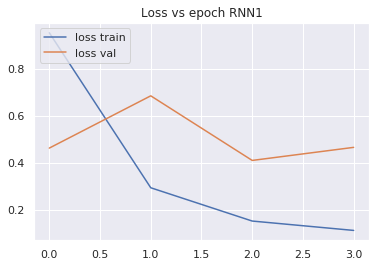

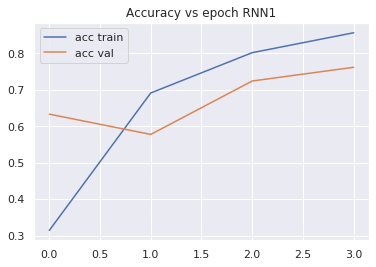


------ Training ------
Accuracy rnn1 : 0.8095465719748702
F1-score None rnn1 : [0.75355921 0.96669009 0.91754386 0.52260327]
F1-score macro rnn1 : 0.790099108595802

------ Validation ------
Accuracy rnn1 : 0.7614117647058823
F1-score None rnn1 : [0.86929331 0.         0.09375    0.55867347]
F1-score macro rnn1 : 0.3804291944263634

------ Testing ------
Accuracy rnn1 : 0.7677814413565709
F1-score None rnn1 : [0.87810722 0.06837607 0.14440433 0.54580897]
F1-score macro rnn1 : 0.40917414627437243


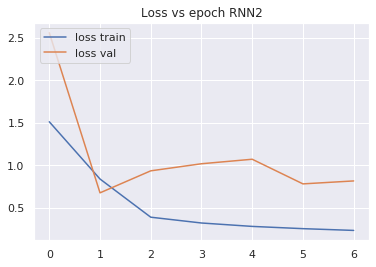

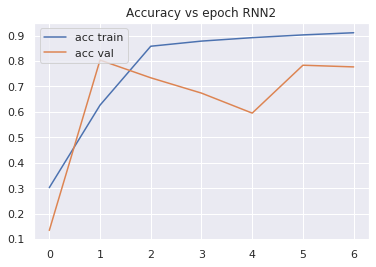


------ Training ------
Accuracy rnn2 : 0.9181917508877356
F1-score None rnn2 : [0.87260975 0.96445698 0.98791873 0.85176282]
F1-score macro rnn2 : 0.9191870694201397

------ Validation ------
Accuracy rnn2 : 0.7769411764705882
F1-score None rnn2 : [0.85834208 0.         0.04       0.6687747 ]
F1-score macro rnn2 : 0.39177919530171

------ Testing ------
Accuracy rnn2 : 0.7220913801224682
F1-score None rnn2 : [0.83034203 0.01851852 0.11881188 0.55350554]
F1-score macro rnn2 : 0.38029448995531245


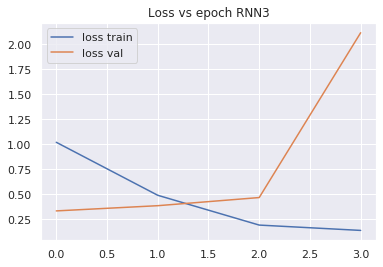

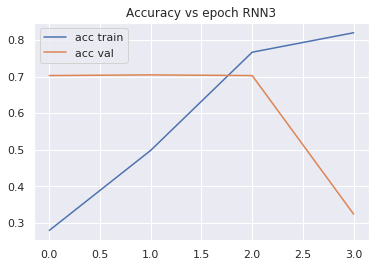


------ Training ------
Accuracy rnn3 : 0.6310434307566238
F1-score None rnn3 : [0.42255697 0.71894654 0.79150327 0.3601178 ]
F1-score macro rnn3 : 0.5732811440496854

------ Validation ------
Accuracy rnn3 : 0.32423529411764707
F1-score None rnn3 : [0.48124696 0.08631579 0.06437768 0.35595391]
F1-score macro rnn3 : 0.246973583200355

------ Testing ------
Accuracy rnn3 : 0.3410268487988695
F1-score None rnn3 : [0.46876468 0.15559772 0.15478615 0.36713287]
F1-score macro rnn3 : 0.28657035476463766

Entrenando exec  3 



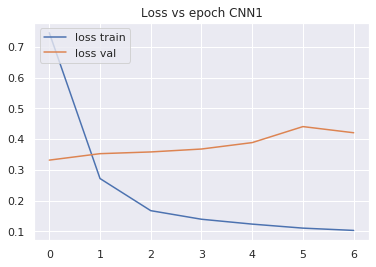

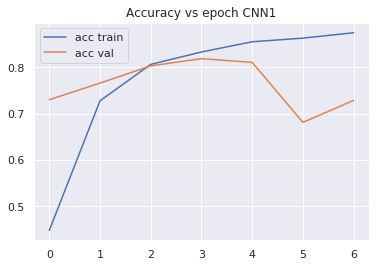


------ Training ------
Accuracy cnn1 : 0.9242693253209505
F1-score None cnn1 : [0.84596717 0.99672131 0.99659354 0.85703043]
F1-score macro cnn1 : 0.9240781123399884

------ Validation ------
Accuracy cnn1 : 0.7284705882352941
F1-score None cnn1 : [0.81259259 0.         0.09756098 0.62491301]
F1-score macro cnn1 : 0.38376664535608473

------ Testing ------
Accuracy cnn1 : 0.6462552991050401
F1-score None cnn1 : [0.7689491  0.         0.05128205 0.48120301]
F1-score macro cnn1 : 0.3253585404233904


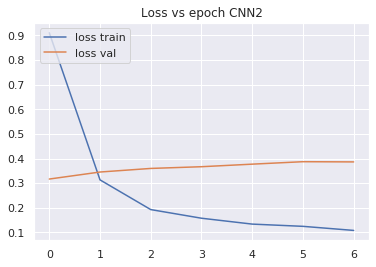

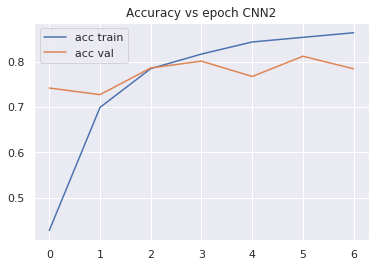


------ Training ------
Accuracy cnn2 : 0.9218792679595739
F1-score None cnn2 : [0.85354873 0.99577254 0.9958994  0.84182306]
F1-score macro cnn2 : 0.9217609297018796

------ Validation ------
Accuracy cnn2 : 0.784
F1-score None cnn2 : [0.86607143 0.         0.05       0.65959184]
F1-score macro cnn2 : 0.39391581632653067

------ Testing ------
Accuracy cnn2 : 0.7583608101742817
F1-score None cnn2 : [0.86222808 0.01851852 0.02597403 0.5842259 ]
F1-score macro cnn2 : 0.3727366317286045


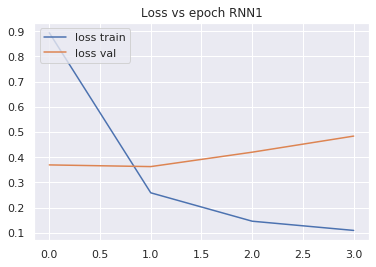

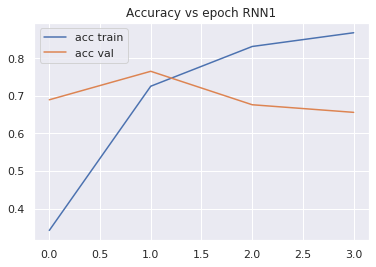


------ Training ------
Accuracy rnn1 : 0.892174269325321
F1-score None rnn1 : [0.79546459 0.9793179  0.97377878 0.81504621]
F1-score macro rnn1 : 0.8909018691223185

------ Validation ------
Accuracy rnn1 : 0.656
F1-score None rnn1 : [0.74801272 0.06666667 0.08602151 0.57511283]
F1-score macro rnn1 : 0.36895343026898597

------ Testing ------
Accuracy rnn1 : 0.5949128591615638
F1-score None rnn1 : [0.72424477 0.03478261 0.13173653 0.45586107]
F1-score macro rnn1 : 0.3366562445121118


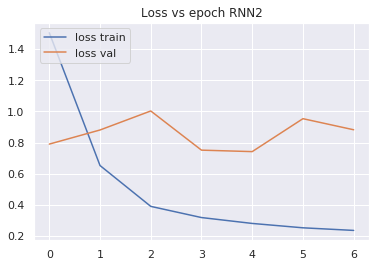

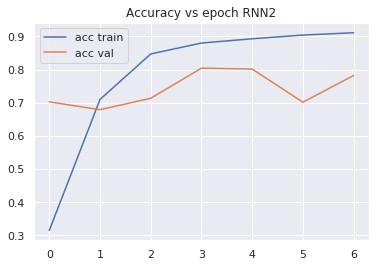


------ Training ------
Accuracy rnn2 : 0.8744878448511336
F1-score None rnn2 : [0.82298515 0.96092619 0.97173192 0.71168744]
F1-score macro rnn2 : 0.8668326739490166

------ Validation ------
Accuracy rnn2 : 0.7821176470588236
F1-score None rnn2 : [0.88438929 0.18681319 0.05084746 0.64864865]
F1-score macro rnn2 : 0.4426746452839956

------ Testing ------
Accuracy rnn2 : 0.7885068299576071
F1-score None rnn2 : [0.88623507 0.25       0.1871345  0.6676876 ]
F1-score macro rnn2 : 0.49776429272941464


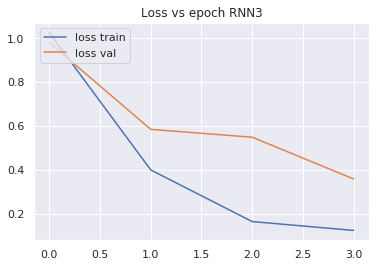

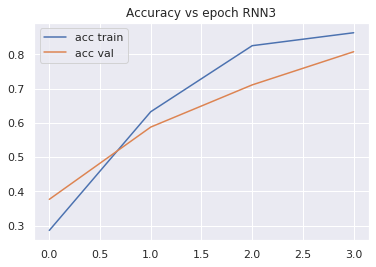


------ Training ------
Accuracy rnn3 : 0.7278748975689703
F1-score None rnn3 : [0.67947461 0.97132997 0.67305259 0.55557402]
F1-score macro rnn3 : 0.7198577981917506

------ Validation ------
Accuracy rnn3 : 0.808
F1-score None rnn3 : [0.88627936 0.13793103 0.1        0.63636364]
F1-score macro rnn3 : 0.44014350701938615

------ Testing ------
Accuracy rnn3 : 0.8134715025906736
F1-score None rnn3 : [0.8955742  0.20238095 0.02531646 0.59409594]
F1-score macro rnn3 : 0.429341886579361

Entrenando exec  4 



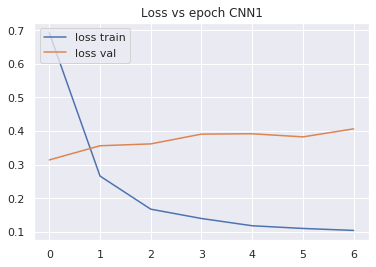

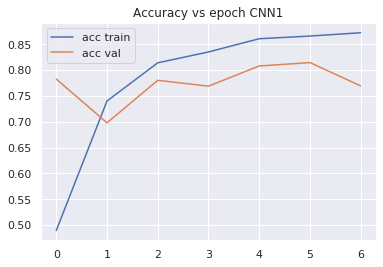


------ Training ------
Accuracy cnn1 : 0.930893198579623
F1-score None cnn1 : [0.8659653  0.99576561 0.99631801 0.86534518]
F1-score macro cnn1 : 0.9308485242967135

------ Validation ------
Accuracy cnn1 : 0.7694117647058824
F1-score None cnn1 : [0.85166785 0.         0.09756098 0.656558  ]
F1-score macro cnn1 : 0.40144670590803394

------ Testing ------
Accuracy cnn1 : 0.7159679698539803
F1-score None cnn1 : [0.83172414 0.         0.02597403 0.53872633]
F1-score macro cnn1 : 0.3491061244530293


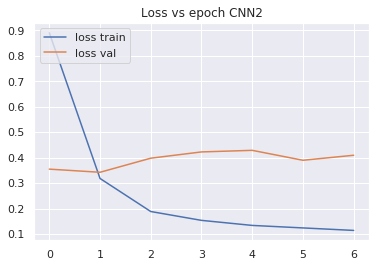

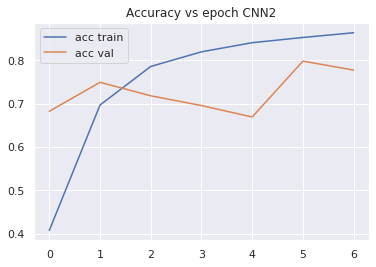


------ Training ------
Accuracy cnn2 : 0.922630428844578
F1-score None cnn2 : [0.85490716 0.99384152 0.99645777 0.84495142]
F1-score macro cnn2 : 0.9225394661483233

------ Validation ------
Accuracy cnn2 : 0.7774117647058824
F1-score None cnn2 : [0.85991678 0.02739726 0.05       0.65442937]
F1-score macro cnn2 : 0.3979358530085051

------ Testing ------
Accuracy cnn2 : 0.7390485162505888
F1-score None cnn2 : [0.85045166 0.01851852 0.05128205 0.55088702]
F1-score macro cnn2 : 0.36778481183702294


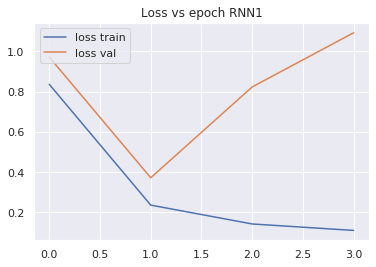

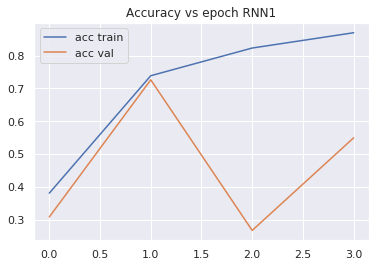


------ Training ------
Accuracy rnn1 : 0.6940726577437859
F1-score None rnn1 : [0.64071493 0.68232224 0.9133429  0.48345035]
F1-score macro rnn1 : 0.6799576070055812

------ Validation ------
Accuracy rnn1 : 0.5496470588235294
F1-score None rnn1 : [0.71857708 0.11805556 0.13513514 0.51918159]
F1-score macro rnn1 : 0.37273733786681357

------ Testing ------
Accuracy rnn1 : 0.5393311351860575
F1-score None rnn1 : [0.70058252 0.182      0.13846154 0.52865065]
F1-score macro rnn1 : 0.3874236774208689


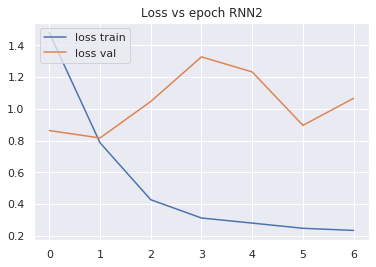

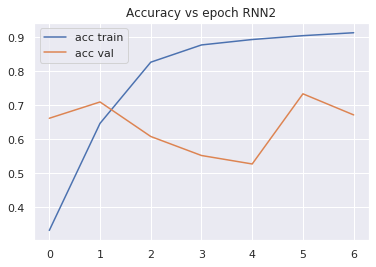


------ Training ------
Accuracy rnn2 : 0.9074706364381316
F1-score None rnn2 : [0.83776673 0.92695278 0.99618112 0.86209286]
F1-score macro rnn2 : 0.905748374909792

------ Validation ------
Accuracy rnn2 : 0.672
F1-score None rnn2 : [0.77532014 0.1221374  0.06779661 0.60798817]
F1-score macro rnn2 : 0.39331058003186004

------ Testing ------
Accuracy rnn2 : 0.6038624587847385
F1-score None rnn2 : [0.71808716 0.24678663 0.14814815 0.51038062]
F1-score macro rnn2 : 0.405850640277155


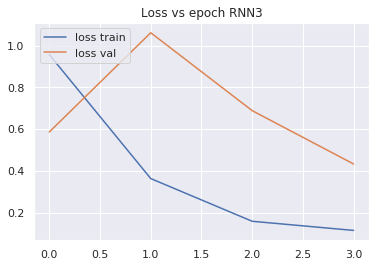

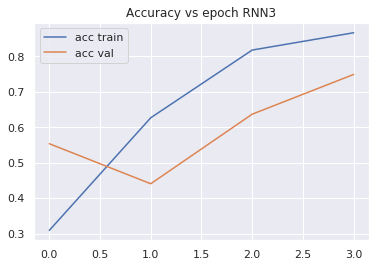


------ Training ------
Accuracy rnn3 : 0.8359054903031958
F1-score None rnn3 : [0.79135338 0.84042385 0.94506068 0.7680163 ]
F1-score macro rnn3 : 0.8362135528801551

------ Validation ------
Accuracy rnn3 : 0.7487058823529412
F1-score None rnn3 : [0.83649635 0.         0.1        0.64900662]
F1-score macro rnn3 : 0.39637574322037994

------ Testing ------
Accuracy rnn3 : 0.6862929816297691
F1-score None rnn3 : [0.80426288 0.         0.16666667 0.52640402]
F1-score macro rnn3 : 0.37433339189479586

Entrenando exec  5 



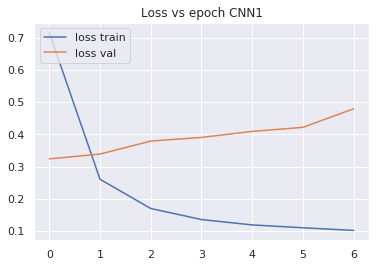

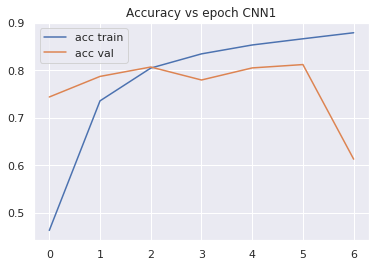


------ Training ------
Accuracy cnn1 : 0.916894291177274
F1-score None cnn1 : [0.82233349 0.996315   0.99494466 0.8510744 ]
F1-score macro cnn1 : 0.9161668874100499

------ Validation ------
Accuracy cnn1 : 0.6131764705882353
F1-score None cnn1 : [0.69272804 0.         0.09756098 0.54266212]
F1-score macro cnn1 : 0.33323778216026095

------ Testing ------
Accuracy cnn1 : 0.5087140838436175
F1-score None cnn1 : [0.62715427 0.         0.         0.39667458]
F1-score macro cnn1 : 0.2559572127053923


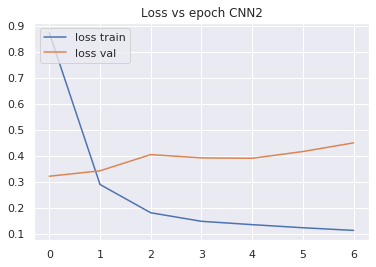

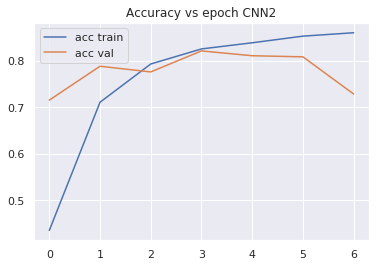


------ Training ------
Accuracy cnn2 : 0.9158016935263589
F1-score None cnn2 : [0.84044501 0.99480022 0.98702016 0.8427393 ]
F1-score macro cnn2 : 0.9162511705987951

------ Validation ------
Accuracy cnn2 : 0.7284705882352941
F1-score None cnn2 : [0.81634155 0.         0.05       0.61646728]
F1-score macro cnn2 : 0.37070220743736426

------ Testing ------
Accuracy cnn2 : 0.6716910032972209
F1-score None cnn2 : [0.7925608  0.         0.02597403 0.50078989]
F1-score macro cnn2 : 0.3298311791335


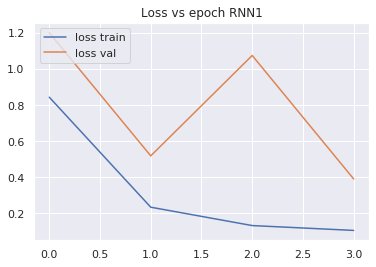

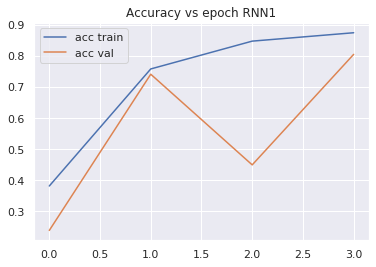


------ Training ------
Accuracy rnn1 : 0.9048757170172084
F1-score None rnn1 : [0.8297491  0.99093904 0.99292902 0.80432875]
F1-score macro rnn1 : 0.9044864794354738

------ Validation ------
Accuracy rnn1 : 0.8056470588235294
F1-score None rnn1 : [0.88259109 0.         0.1        0.69860627]
F1-score macro rnn1 : 0.42029934122360313

------ Testing ------
Accuracy rnn1 : 0.7814413565708902
F1-score None rnn1 : [0.88130081 0.0952381  0.1300813  0.62906725]
F1-score macro rnn1 : 0.4339218635446348


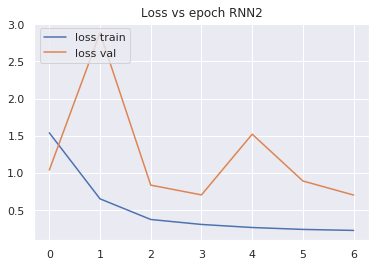

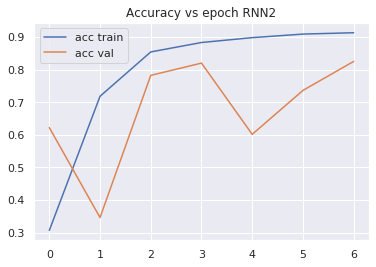


------ Training ------
Accuracy rnn2 : 0.8991395793499044
F1-score None rnn2 : [0.82575296 0.99523485 0.96968003 0.80668185]
F1-score macro rnn2 : 0.8993374242068815

------ Validation ------
Accuracy rnn2 : 0.8249411764705883
F1-score None rnn2 : [0.89617132 0.02325581 0.15384615 0.71262136]
F1-score macro rnn2 : 0.44647366108733866

------ Testing ------
Accuracy rnn2 : 0.8120584079133302
F1-score None rnn2 : [0.89426357 0.08823529 0.12765957 0.68268015]
F1-score macro rnn2 : 0.4482096465459764


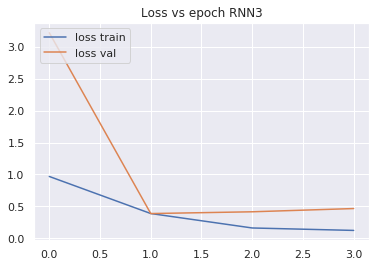

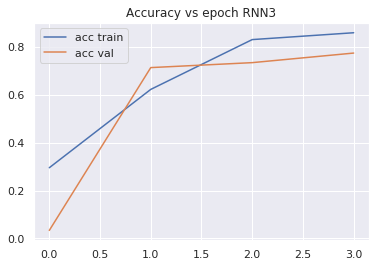


------ Training ------
Accuracy rnn3 : 0.8386369844304835
F1-score None rnn3 : [0.77365685 0.98178332 0.93452457 0.61415317]
F1-score macro rnn3 : 0.8260294767017674

------ Validation ------
Accuracy rnn3 : 0.7741176470588236
F1-score None rnn3 : [0.87628205 0.08602151 0.08839779 0.62149533]
F1-score macro rnn3 : 0.418049168454112

------ Testing ------
Accuracy rnn3 : 0.7894488930758361
F1-score None rnn3 : [0.88650964 0.14814815 0.18326693 0.65651438]
F1-score macro rnn3 : 0.468609774699019


In [21]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [22]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5)

0.15 Clase Ponderado - F1-score promedio para cnn1 : [0.79304963 0.         0.0307726  0.52557354]
0.15 Clase Ponderado - F1-score promedio para cnn2 : [0.85135232 0.00740741 0.03590081 0.57259936]
0.15 Clase Ponderado - F1-score promedio para rnn1 : [0.67903457 0.11630282 0.14355212 0.49522504]
0.15 Clase Ponderado - F1-score promedio para rnn2 : [0.83073402 0.13393123 0.14645835 0.5922982 ]
0.15 Clase Ponderado - F1-score promedio para rnn3 : [0.77223955 0.12726087 0.14284935 0.53619978]

0.15 Clase Ponderado - F1-score macro promedio para cnn1 : 0.33734894523984843 desvest:  0.04828363791063177
0.15 Clase Ponderado - F1-score macro promedio para cnn2 : 0.366814975258244 desvest:  0.019295798548966184
0.15 Clase Ponderado - F1-score macro promedio para rnn1 : 0.3585286378328111 desvest:  0.07384817109500123
0.15 Clase Ponderado - F1-score macro promedio para rnn2 : 0.4258554479804726 desvest:  0.04235591839376553
0.15 Clase Ponderado - F1-score macro promedio para rnn3 : 0.3946373848

#### Sujeto a Vocabulario BERT

In [23]:
macro_augmented = np.load('../Datasets/CSV_Harassment/balance_bert_noPon.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



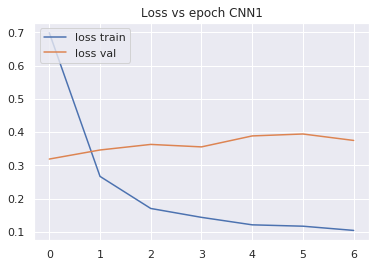

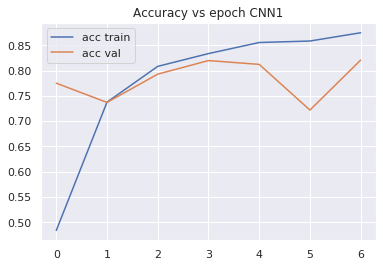


------ Training ------
Accuracy cnn1 : 0.914777383228626
F1-score None cnn1 : [0.84690799 0.99604743 0.99700436 0.81551646]
F1-score macro cnn1 : 0.9138690614462507

------ Validation ------
Accuracy cnn1 : 0.8207058823529412
F1-score None cnn1 : [0.89180328 0.02702703 0.09756098 0.70230415]
F1-score macro cnn1 : 0.42967385719768636

------ Testing ------
Accuracy cnn1 : 0.8106453132359868
F1-score None cnn1 : [0.8970451  0.         0.05128205 0.65484634]
F1-score macro cnn1 : 0.4007933720170245


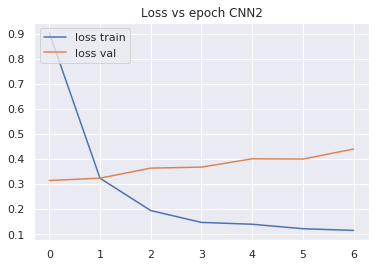

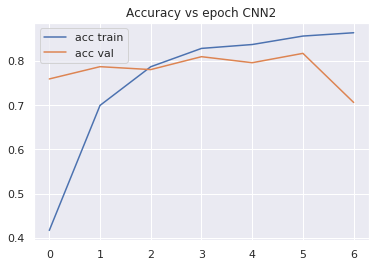


------ Training ------
Accuracy cnn2 : 0.9153236820540835
F1-score None cnn2 : [0.82981121 0.99589828 0.99673203 0.83828996]
F1-score macro cnn2 : 0.9151828701680312

------ Validation ------
Accuracy cnn2 : 0.7063529411764706
F1-score None cnn2 : [0.79702048 0.         0.09302326 0.59172414]
F1-score macro cnn2 : 0.37044196947907754

------ Testing ------
Accuracy cnn2 : 0.647197362223269
F1-score None cnn2 : [0.77301063 0.         0.09876543 0.47447447]
F1-score macro cnn2 : 0.33656263524250324


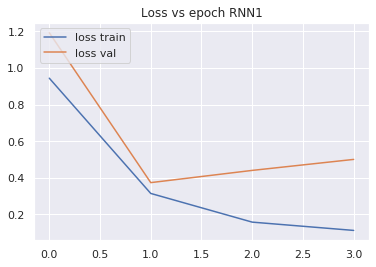

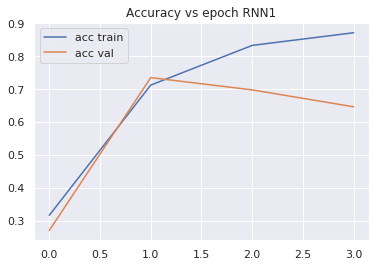


------ Training ------
Accuracy rnn1 : 0.8818628789948102
F1-score None rnn1 : [0.78948922 0.97654407 0.94449476 0.81055409]
F1-score macro rnn1 : 0.8802705349566534

------ Validation ------
Accuracy rnn1 : 0.6465882352941177
F1-score None rnn1 : [0.74451973 0.02325581 0.02597403 0.58227848]
F1-score macro rnn1 : 0.34400701247896504

------ Testing ------
Accuracy rnn1 : 0.5737164390014131
F1-score None rnn1 : [0.69866247 0.06666667 0.18032787 0.45373134]
F1-score macro rnn1 : 0.34984708732459513


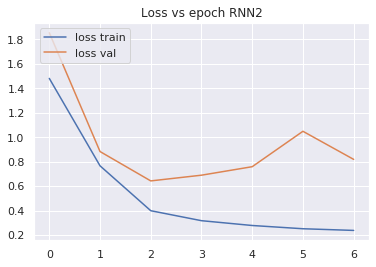

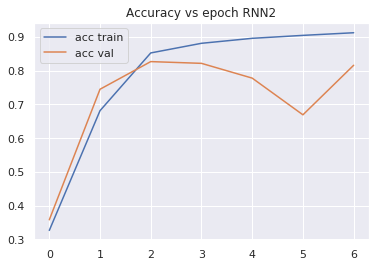


------ Training ------
Accuracy rnn2 : 0.6372575798962032
F1-score None rnn2 : [0.5737071  0.55016822 0.84727672 0.61724771]
F1-score macro rnn2 : 0.6470999377134901

------ Validation ------
Accuracy rnn2 : 0.816
F1-score None rnn2 : [0.88767787 0.         0.05       0.63952096]
F1-score macro rnn2 : 0.39429970667203285

------ Testing ------
Accuracy rnn2 : 0.8181818181818182
F1-score None rnn2 : [0.89390519 0.         0.07594937 0.58027079]
F1-score macro rnn2 : 0.3875313379997368


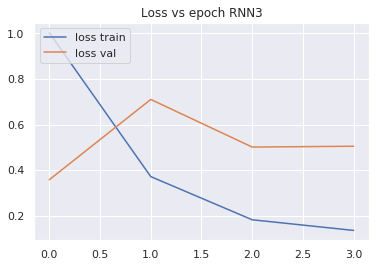

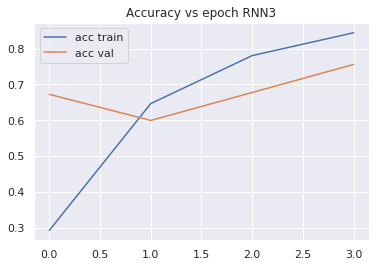


------ Training ------
Accuracy rnn3 : 0.8488118000546299
F1-score None rnn3 : [0.78054028 0.98802721 0.93631714 0.65125174]
F1-score macro rnn3 : 0.8390340917635367

------ Validation ------
Accuracy rnn3 : 0.756235294117647
F1-score None rnn3 : [0.86271915 0.02409639 0.08256881 0.63282937]
F1-score macro rnn3 : 0.4005534299227099

------ Testing ------
Accuracy rnn3 : 0.7508243052284503
F1-score None rnn3 : [0.86418193 0.10526316 0.17361111 0.58877086]
F1-score macro rnn3 : 0.4329567667478179

Entrenando exec  2 



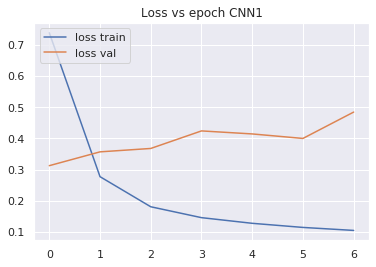

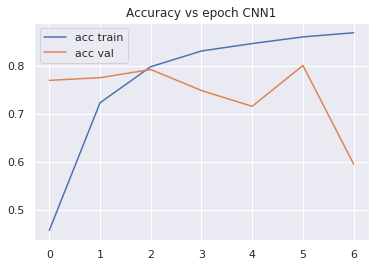


------ Training ------
Accuracy cnn1 : 0.9149139579349904
F1-score None cnn1 : [0.81636364 0.99536279 0.99645293 0.84799402]
F1-score macro cnn1 : 0.9140433455467583

------ Validation ------
Accuracy cnn1 : 0.5952941176470589
F1-score None cnn1 : [0.67261146 0.         0.09756098 0.52861953]
F1-score macro cnn1 : 0.3246979922993594

------ Testing ------
Accuracy cnn1 : 0.4889307583608102
F1-score None cnn1 : [0.59957173 0.         0.05128205 0.38911407]
F1-score macro cnn1 : 0.2599919641000398


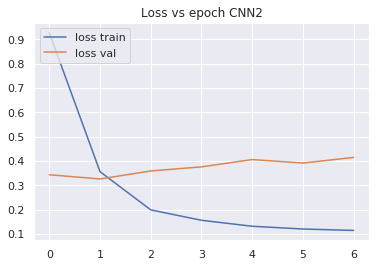

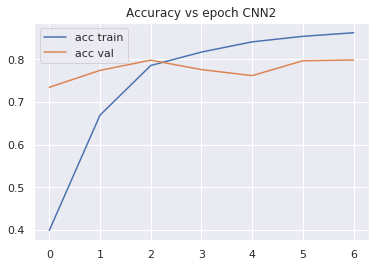


------ Training ------
Accuracy cnn2 : 0.9164845670581808
F1-score None cnn2 : [0.84934303 0.99481016 0.99494052 0.82535955]
F1-score macro cnn2 : 0.9161133150882735

------ Validation ------
Accuracy cnn2 : 0.7985882352941176
F1-score None cnn2 : [0.87588295 0.         0.09756098 0.67525773]
F1-score macro cnn2 : 0.41217541352179676

------ Testing ------
Accuracy cnn2 : 0.7776731040979745
F1-score None cnn2 : [0.87496003 0.         0.02597403 0.6025641 ]
F1-score macro cnn2 : 0.37587453853043873


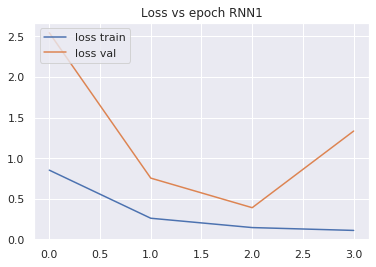

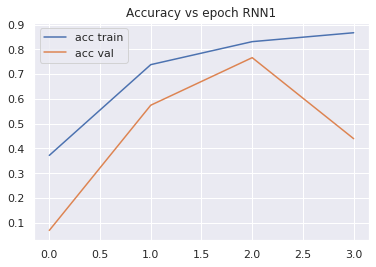


------ Training ------
Accuracy rnn1 : 0.6315214422288992
F1-score None rnn1 : [0.63524057 0.83841237 0.61919662 0.35471204]
F1-score macro rnn1 : 0.6118903998653991

------ Validation ------
Accuracy rnn1 : 0.4395294117647059
F1-score None rnn1 : [0.65337293 0.02702703 0.04142012 0.38577291]
F1-score macro rnn1 : 0.27689824771993543

------ Testing ------
Accuracy rnn1 : 0.43099387658973154
F1-score None rnn1 : [0.61372141 0.1865285  0.11111111 0.38306452]
F1-score macro rnn1 : 0.3236063845927209


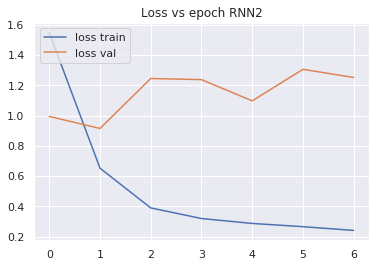

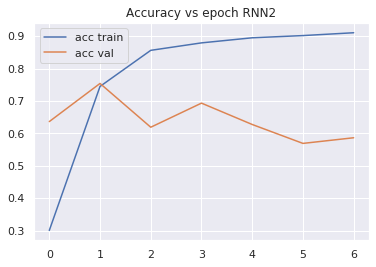


------ Training ------
Accuracy rnn2 : 0.9073340617317672
F1-score None rnn2 : [0.79250675 0.99289423 0.99550592 0.84125841]
F1-score macro rnn2 : 0.9055413274721302

------ Validation ------
Accuracy rnn2 : 0.5863529411764706
F1-score None rnn2 : [0.66063738 0.         0.09375    0.53363229]
F1-score macro rnn2 : 0.32200491714078244

------ Testing ------
Accuracy rnn2 : 0.49222797927461137
F1-score None rnn2 : [0.59768141 0.09677419 0.17391304 0.39690107]
F1-score macro rnn2 : 0.3163174295155013


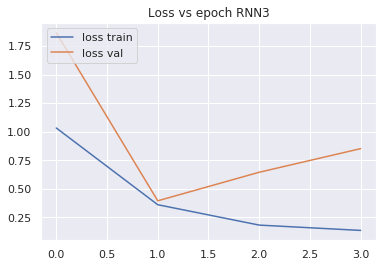

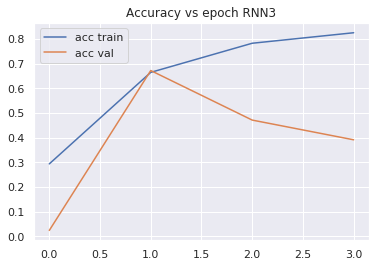


------ Training ------
Accuracy rnn3 : 0.7403714832013111
F1-score None rnn3 : [0.54180855 0.91971851 0.819841   0.62826838]
F1-score macro rnn3 : 0.7274091107958809

------ Validation ------
Accuracy rnn3 : 0.3910588235294118
F1-score None rnn3 : [0.45395068 0.03305785 0.04892966 0.4077135 ]
F1-score macro rnn3 : 0.23591292322175675

------ Testing ------
Accuracy rnn3 : 0.33820065944418276
F1-score None rnn3 : [0.41601562 0.1125     0.20330969 0.29721362]
F1-score macro rnn3 : 0.2572597349906041

Entrenando exec  3 



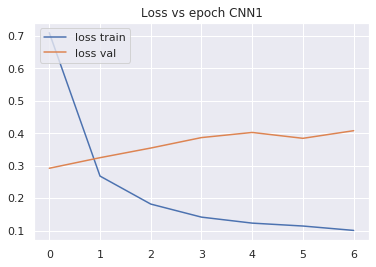

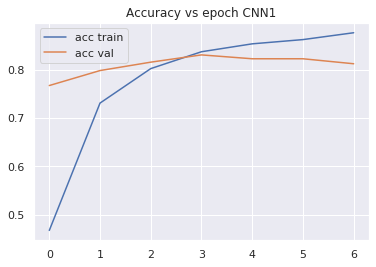


------ Training ------
Accuracy cnn1 : 0.9225621414913958
F1-score None cnn1 : [0.85732781 0.99618529 0.99617695 0.83913043]
F1-score macro cnn1 : 0.9222051206990751

------ Validation ------
Accuracy cnn1 : 0.8127058823529412
F1-score None cnn1 : [0.88621955 0.         0.09756098 0.69710272]
F1-score macro cnn1 : 0.4202208125454162

------ Testing ------
Accuracy cnn1 : 0.7936881771078662
F1-score None cnn1 : [0.88931419 0.         0.02597403 0.625     ]
F1-score macro cnn1 : 0.3850720551378446


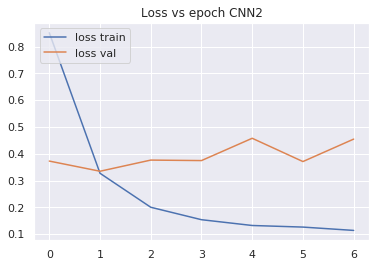

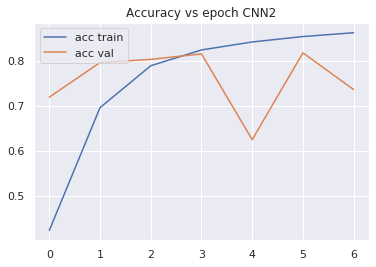


------ Training ------
Accuracy cnn2 : 0.9218109806063917
F1-score None cnn2 : [0.84105488 0.99631902 0.99686435 0.85203209]
F1-score macro cnn2 : 0.9215675856015982

------ Validation ------
Accuracy cnn2 : 0.736
F1-score None cnn2 : [0.82301209 0.         0.09756098 0.62357955]
F1-score macro cnn2 : 0.38603815335145464

------ Testing ------
Accuracy cnn2 : 0.6952425812529439
F1-score None cnn2 : [0.81718915 0.         0.02597403 0.51470588]
F1-score macro cnn2 : 0.33946726485912826


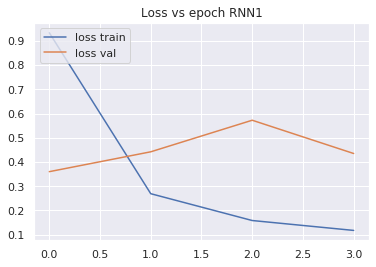

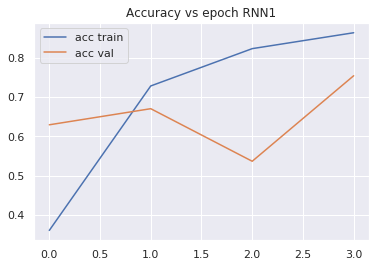


------ Training ------
Accuracy rnn1 : 0.8406856050259492
F1-score None rnn1 : [0.79472693 0.99154622 0.91874922 0.59727025]
F1-score macro rnn1 : 0.8255731535471499

------ Validation ------
Accuracy rnn1 : 0.7543529411764706
F1-score None rnn1 : [0.87328543 0.04210526 0.07239819 0.58715596]
F1-score macro rnn1 : 0.3937362127156314

------ Testing ------
Accuracy rnn1 : 0.7668393782383419
F1-score None rnn1 : [0.88170693 0.20915033 0.20618557 0.57560976]
F1-score macro rnn1 : 0.4681631460815854


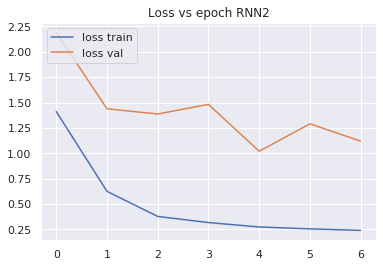

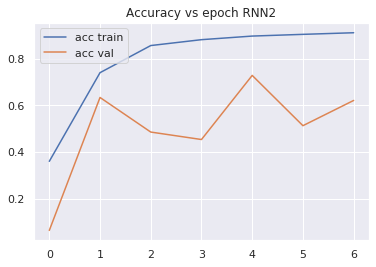


------ Training ------
Accuracy rnn2 : 0.8845943731220978
F1-score None rnn2 : [0.78885215 0.96346452 0.97775924 0.81280333]
F1-score macro rnn2 : 0.8857198108806514

------ Validation ------
Accuracy rnn2 : 0.6216470588235294
F1-score None rnn2 : [0.70004207 0.         0.08695652 0.55593607]
F1-score macro rnn2 : 0.3357336661586048

------ Testing ------
Accuracy rnn2 : 0.5181347150259067
F1-score None rnn2 : [0.63591022 0.         0.11363636 0.40097205]
F1-score macro rnn2 : 0.28762966038455173


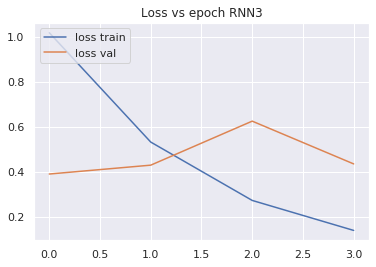

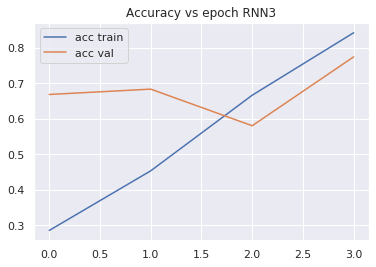


------ Training ------
Accuracy rnn3 : 0.8828871892925431
F1-score None rnn3 : [0.80158934 0.97586484 0.98496446 0.76281287]
F1-score macro rnn3 : 0.8813078782776812

------ Validation ------
Accuracy rnn3 : 0.7741176470588236
F1-score None rnn3 : [0.86108239 0.09929078 0.11267606 0.67722076]
F1-score macro rnn3 : 0.43756749456016286

------ Testing ------
Accuracy rnn3 : 0.7461139896373057
F1-score None rnn3 : [0.85302013 0.23045267 0.18965517 0.60418964]
F1-score macro rnn3 : 0.4693294044255689

Entrenando exec  4 



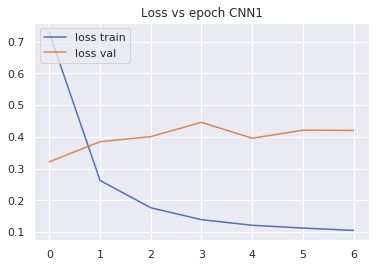

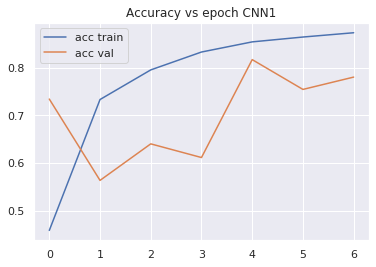


------ Training ------
Accuracy cnn1 : 0.9263179459164163
F1-score None cnn1 : [0.85710371 0.99563676 0.99673114 0.85518939]
F1-score macro cnn1 : 0.9261652494554751

------ Validation ------
Accuracy cnn1 : 0.780235294117647
F1-score None cnn1 : [0.85935302 0.         0.0952381  0.67182663]
F1-score macro cnn1 : 0.4066044361337695

------ Testing ------
Accuracy cnn1 : 0.7395195478097033
F1-score None cnn1 : [0.84620551 0.         0.07407407 0.5679926 ]
F1-score macro cnn1 : 0.3720680451426863


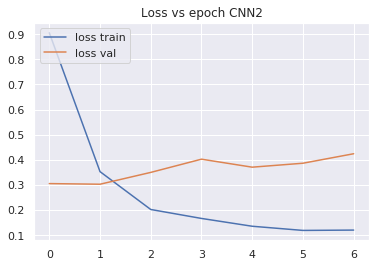

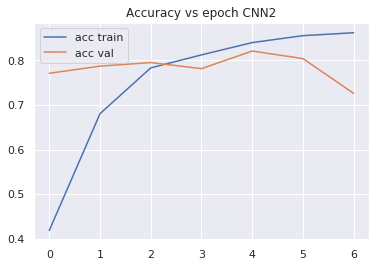


------ Training ------
Accuracy cnn2 : 0.9211281070745698
F1-score None cnn2 : [0.84392898 0.99481441 0.9931638  0.8522579 ]
F1-score macro cnn2 : 0.921041270644676

------ Validation ------
Accuracy cnn2 : 0.7261176470588235
F1-score None cnn2 : [0.81083086 0.         0.09756098 0.62179042]
F1-score macro cnn2 : 0.38254556486525537

------ Testing ------
Accuracy cnn2 : 0.6650965614696185
F1-score None cnn2 : [0.78816312 0.         0.02597403 0.49380805]
F1-score macro cnn2 : 0.3269862983793923


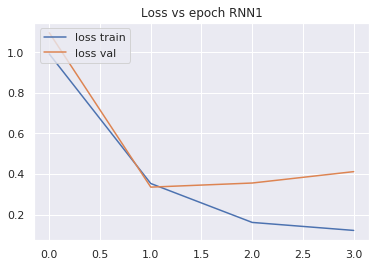

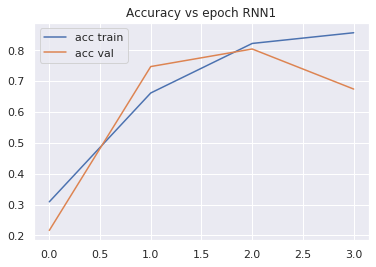


------ Training ------
Accuracy rnn1 : 0.8887599016662114
F1-score None rnn1 : [0.78952069 0.98694588 0.96895425 0.80691057]
F1-score macro rnn1 : 0.888082846986691

------ Validation ------
Accuracy rnn1 : 0.6743529411764706
F1-score None rnn1 : [0.76502732 0.11320755 0.06122449 0.59838275]
F1-score macro rnn1 : 0.38446052717406165

------ Testing ------
Accuracy rnn1 : 0.610456900612341
F1-score None rnn1 : [0.73417722 0.20606061 0.18181818 0.46666667]
F1-score macro rnn1 : 0.39718066743383196


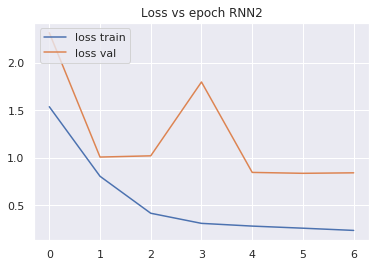

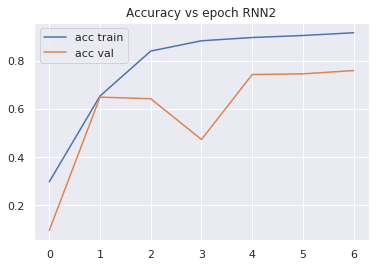


------ Training ------
Accuracy rnn2 : 0.9293908768096149
F1-score None rnn2 : [0.87304688 0.97742151 0.99293094 0.87127353]
F1-score macro rnn2 : 0.9286682129995044

------ Validation ------
Accuracy rnn2 : 0.7590588235294118
F1-score None rnn2 : [0.85100287 0.05217391 0.05970149 0.65830721]
F1-score macro rnn2 : 0.40529637023541315

------ Testing ------
Accuracy rnn2 : 0.7098445595854922
F1-score None rnn2 : [0.82491349 0.12290503 0.17094017 0.55471698]
F1-score macro rnn2 : 0.41836891870372395


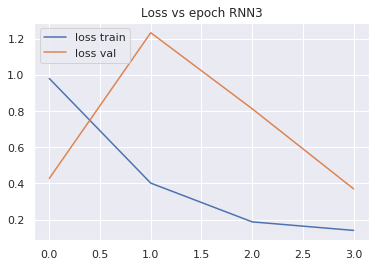

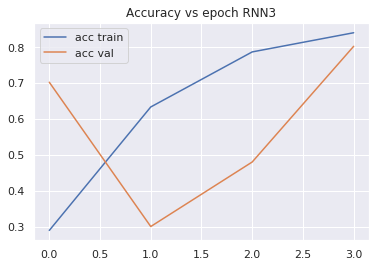


------ Training ------
Accuracy rnn3 : 0.8090002731494127
F1-score None rnn3 : [0.75545852 0.9822534  0.89961159 0.58588808]
F1-score macro rnn3 : 0.8058028976208973

------ Validation ------
Accuracy rnn3 : 0.8023529411764706
F1-score None rnn3 : [0.88012422 0.025      0.125      0.62971175]
F1-score macro rnn3 : 0.4149589938163639

------ Testing ------
Accuracy rnn3 : 0.8092322185586435
F1-score None rnn3 : [0.89255225 0.01785714 0.11494253 0.60307692]
F1-score macro rnn3 : 0.4071072116641864

Entrenando exec  5 



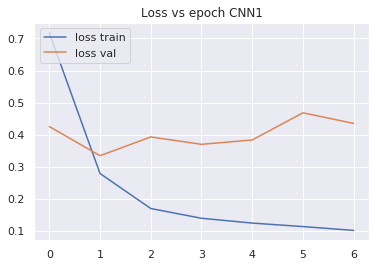

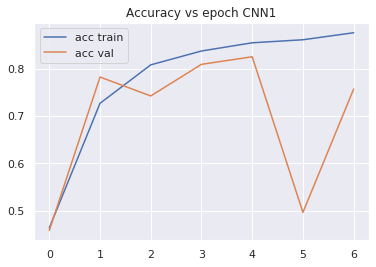


------ Training ------
Accuracy cnn1 : 0.9296640262223437
F1-score None cnn1 : [0.85981569 0.995214   0.99727372 0.86612278]
F1-score macro cnn1 : 0.9296065478910048

------ Validation ------
Accuracy cnn1 : 0.7571764705882353
F1-score None cnn1 : [0.84081926 0.         0.09756098 0.64549483]
F1-score macro cnn1 : 0.3959687663835718

------ Testing ------
Accuracy cnn1 : 0.6914743287800282
F1-score None cnn1 : [0.8105039  0.         0.02597403 0.52208835]
F1-score macro cnn1 : 0.3396415707163311


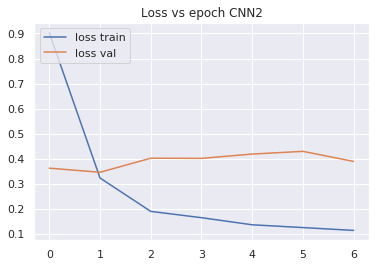

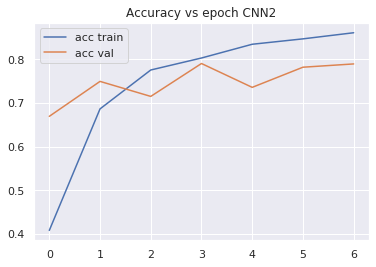


------ Training ------
Accuracy cnn2 : 0.9230401529636711
F1-score None cnn2 : [0.85261745 0.99536153 0.99713935 0.84637924]
F1-score macro cnn2 : 0.9228743925295145

------ Validation ------
Accuracy cnn2 : 0.7891764705882353
F1-score None cnn2 : [0.86791148 0.         0.09302326 0.67578439]
F1-score macro cnn2 : 0.40917978208929506

------ Testing ------
Accuracy cnn2 : 0.7663683466792275
F1-score None cnn2 : [0.86879316 0.         0.05       0.5966634 ]
F1-score macro cnn2 : 0.3788641389076149


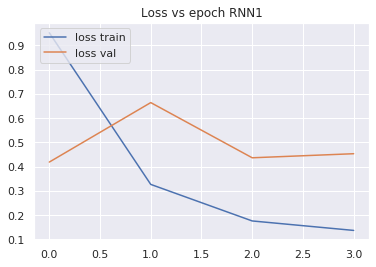

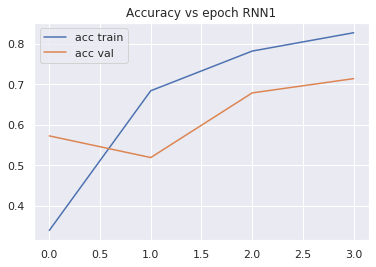


------ Training ------
Accuracy rnn1 : 0.8559136847855777
F1-score None rnn1 : [0.79008439 0.97256991 0.93440531 0.69990563]
F1-score macro rnn1 : 0.8492413086272785

------ Validation ------
Accuracy rnn1 : 0.7143529411764706
F1-score None rnn1 : [0.83315845 0.05369128 0.09574468 0.59582543]
F1-score macro rnn1 : 0.39460495749331614

------ Testing ------
Accuracy rnn1 : 0.7041921808761187
F1-score None rnn1 : [0.8332772  0.19387755 0.16194332 0.52517986]
F1-score macro rnn1 : 0.42856948117080984


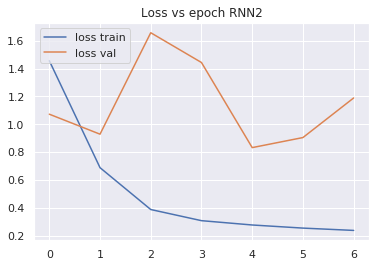

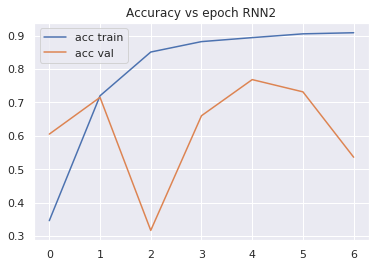


------ Training ------
Accuracy rnn2 : 0.8997541655285441
F1-score None rnn2 : [0.76616752 0.99549242 0.99496256 0.83089526]
F1-score macro rnn2 : 0.8968794389714572

------ Validation ------
Accuracy rnn2 : 0.536
F1-score None rnn2 : [0.59494253 0.02247191 0.05882353 0.50990615]
F1-score macro rnn2 : 0.2965360301254188

------ Testing ------
Accuracy rnn2 : 0.42016015073009894
F1-score None rnn2 : [0.50760018 0.07874016 0.10909091 0.35908596]
F1-score macro rnn2 : 0.2636293034553448


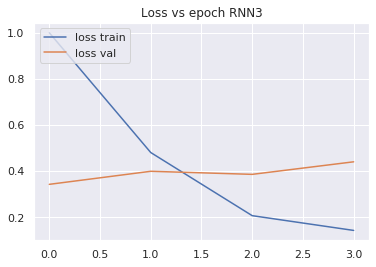

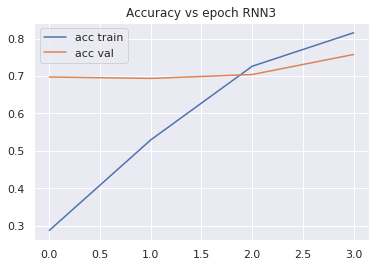


------ Training ------
Accuracy rnn3 : 0.8432122370936902
F1-score None rnn3 : [0.77203222 0.95494319 0.97913881 0.61725743]
F1-score macro rnn3 : 0.8308429105847671

------ Validation ------
Accuracy rnn3 : 0.7576470588235295
F1-score None rnn3 : [0.85977617 0.15841584 0.07272727 0.63111111]
F1-score macro rnn3 : 0.4305075984886178

------ Testing ------
Accuracy rnn3 : 0.7682524729156853
F1-score None rnn3 : [0.87111111 0.21843003 0.1686747  0.66875981]
F1-score macro rnn3 : 0.4817439139132348


In [24]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [25]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 BERT - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 BERT - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 BERT - Accuracy promedio para",key,":" ,temp/5)

0.15 BERT - F1-score promedio para cnn1 : [0.80852809 0.         0.04571725 0.55180827]
0.15 BERT - F1-score promedio para cnn2 : [0.82442322 0.         0.0453375  0.53644318]
0.15 BERT - F1-score promedio para rnn1 : [0.75230905 0.17245673 0.16827721 0.48085043]
0.15 BERT - F1-score promedio para rnn2 : [0.6920021  0.05968388 0.12870597 0.45838937]
0.15 BERT - F1-score promedio para rnn3 : [0.77937621 0.1369006  0.17003864 0.55240217]

0.15 BERT - F1-score macro promedio para cnn1 : 0.35151340142278525 desvest:  0.04998861064949166
0.15 BERT - F1-score macro promedio para cnn2 : 0.35155097518381545 desvest:  0.021502252823336072
0.15 BERT - F1-score macro promedio para rnn1 : 0.3934733533207086 desvest:  0.052170282565207546
0.15 BERT - F1-score macro promedio para rnn2 : 0.3346953300117717 desvest:  0.05898511303595598
0.15 BERT - F1-score macro promedio para rnn3 : 0.4096794063482824 desvest:  0.08066179198436492

0.15 BERT - Accuracy promedio para cnn1 : 0.704851625058879
0.15 BERT

In [26]:
macro_augmented = np.load('../Datasets/CSV_Harassment/balance_bert_Pon.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



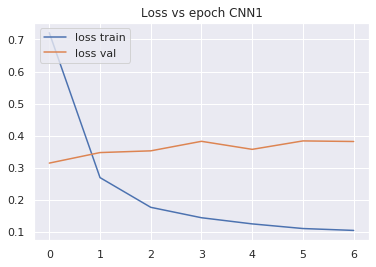

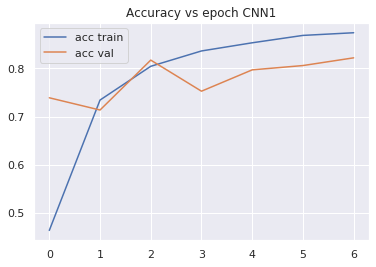


------ Training ------
Accuracy cnn1 : 0.900437039060366
F1-score None cnn1 : [0.82834835 0.99481441 0.99672757 0.77384542]
F1-score macro cnn1 : 0.8984339376028189

------ Validation ------
Accuracy cnn1 : 0.8216470588235294
F1-score None cnn1 : [0.89507358 0.         0.09756098 0.68316832]
F1-score macro cnn1 : 0.4189507172242434

------ Testing ------
Accuracy cnn1 : 0.8290155440414507
F1-score None cnn1 : [0.90713002 0.         0.02597403 0.67586207]
F1-score macro cnn1 : 0.40224152822859466


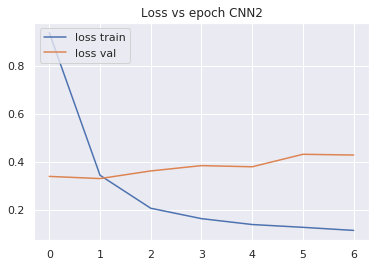

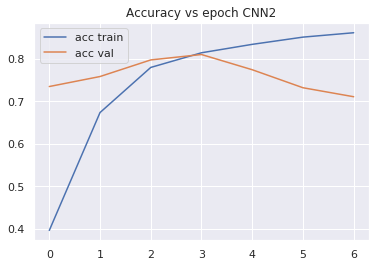


------ Training ------
Accuracy cnn2 : 0.9247473367932258
F1-score None cnn2 : [0.84765569 0.99536658 0.99700354 0.85785799]
F1-score macro cnn2 : 0.9244709523027081

------ Validation ------
Accuracy cnn2 : 0.7105882352941176
F1-score None cnn2 : [0.79833837 0.         0.13953488 0.60606061]
F1-score macro cnn2 : 0.3859834645903991

------ Testing ------
Accuracy cnn2 : 0.6420160150730099
F1-score None cnn2 : [0.76798229 0.         0.05128205 0.47372317]
F1-score macro cnn2 : 0.32324687841551586


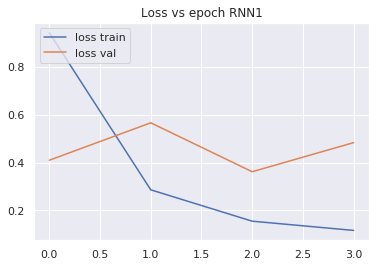

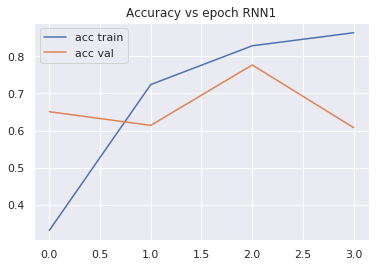


------ Training ------
Accuracy rnn1 : 0.8926522807975963
F1-score None rnn1 : [0.77087199 0.98286793 0.98845266 0.81978623]
F1-score macro rnn1 : 0.8904947012345854

------ Validation ------
Accuracy rnn1 : 0.608
F1-score None rnn1 : [0.6898575  0.07092199 0.10810811 0.55791389]
F1-score macro rnn1 : 0.35670037080590866

------ Testing ------
Accuracy rnn1 : 0.5115402731983043
F1-score None rnn1 : [0.6236831  0.19587629 0.1641791  0.40906149]
F1-score macro rnn1 : 0.3481999958424382


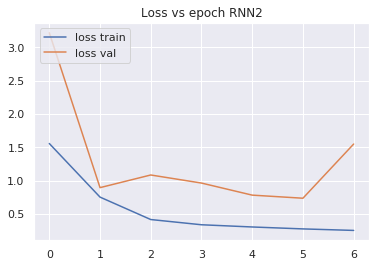

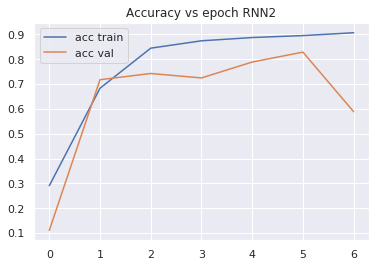


------ Training ------
Accuracy rnn2 : 0.8835700628243649
F1-score None rnn2 : [0.81983931 0.99279598 0.90607598 0.80590946]
F1-score macro rnn2 : 0.8811551814155432

------ Validation ------
Accuracy rnn2 : 0.5887058823529412
F1-score None rnn2 : [0.70274771 0.06666667 0.03773585 0.56312057]
F1-score macro rnn2 : 0.34256769833515555

------ Testing ------
Accuracy rnn2 : 0.5463966085727744
F1-score None rnn2 : [0.6674777  0.23863636 0.17886179 0.4582996 ]
F1-score macro rnn2 : 0.38581886101768176


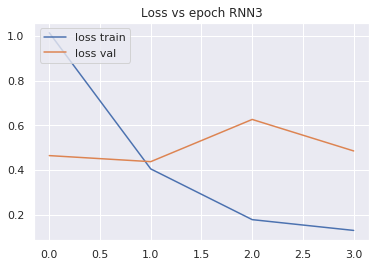

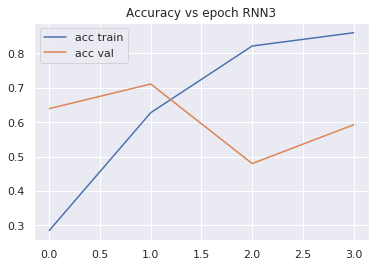


------ Training ------
Accuracy rnn3 : 0.8594646271510517
F1-score None rnn3 : [0.74198667 0.9764984  0.95282751 0.77286742]
F1-score macro rnn3 : 0.8610449999602585

------ Validation ------
Accuracy rnn3 : 0.5924705882352941
F1-score None rnn3 : [0.66580311 0.         0.0625     0.5421082 ]
F1-score macro rnn3 : 0.31760282683955166

------ Testing ------
Accuracy rnn3 : 0.48233631653320774
F1-score None rnn3 : [0.59073192 0.01709402 0.0952381  0.39183673]
F1-score macro rnn3 : 0.27372519140136536

Entrenando exec  2 



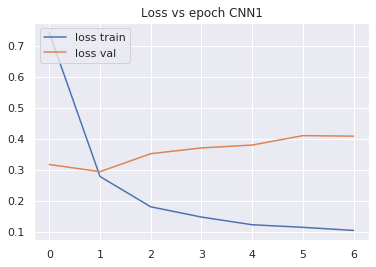

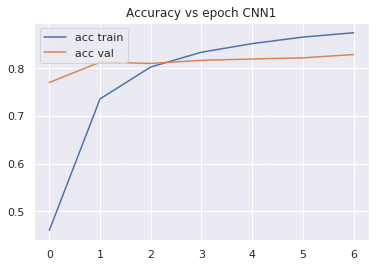


------ Training ------
Accuracy cnn1 : 0.9052854411363016
F1-score None cnn1 : [0.83531868 0.99508062 0.995632   0.7900323 ]
F1-score macro cnn1 : 0.9040159000238496

------ Validation ------
Accuracy cnn1 : 0.8291764705882353
F1-score None cnn1 : [0.89635317 0.         0.09756098 0.71018793]
F1-score macro cnn1 : 0.4260255188340455

------ Testing ------
Accuracy cnn1 : 0.8318417333961375
F1-score None cnn1 : [0.90690691 0.         0.02597403 0.6957708 ]
F1-score macro cnn1 : 0.40716293444806406


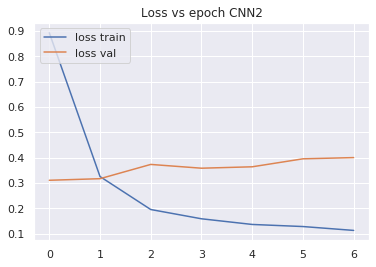

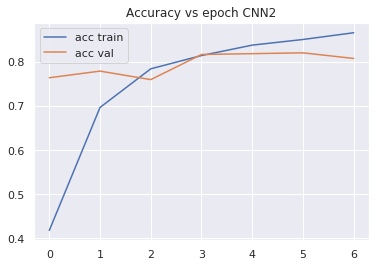


------ Training ------
Accuracy cnn2 : 0.9210598197213876
F1-score None cnn2 : [0.85397074 0.99550347 0.99508331 0.83861713]
F1-score macro cnn2 : 0.9207936637906536

------ Validation ------
Accuracy cnn2 : 0.808
F1-score None cnn2 : [0.88088829 0.         0.09756098 0.69699571]
F1-score macro cnn2 : 0.4188612436193967

------ Testing ------
Accuracy cnn2 : 0.7828544512482336
F1-score None cnn2 : [0.87928274 0.         0.02597403 0.61276596]
F1-score macro cnn2 : 0.3795056810937613


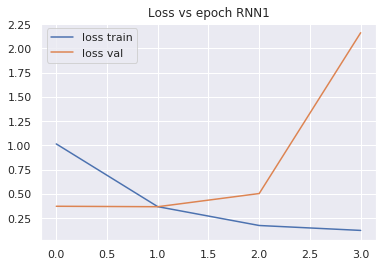

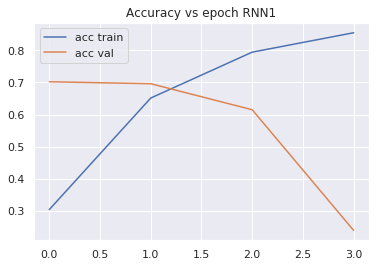


------ Training ------
Accuracy rnn1 : 0.6750204862059547
F1-score None rnn1 : [0.3082878  0.74790603 0.83244227 0.59794141]
F1-score macro rnn1 : 0.6216443755992962

------ Validation ------
Accuracy rnn1 : 0.23952941176470588
F1-score None rnn1 : [0.20310633 0.07517084 0.07692308 0.47674419]
F1-score macro rnn1 : 0.20798610948319501

------ Testing ------
Accuracy rnn1 : 0.20065944418276024
F1-score None rnn1 : [0.15224913 0.15451578 0.15333333 0.35649547]
F1-score macro rnn1 : 0.2041484286447406


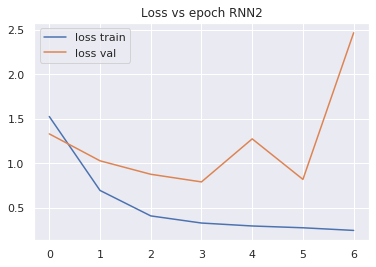

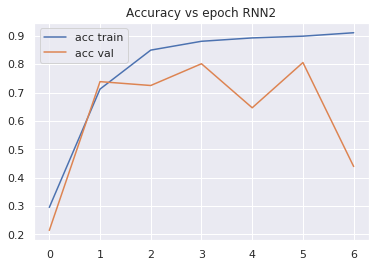


------ Training ------
Accuracy rnn2 : 0.7670718382955477
F1-score None rnn2 : [0.68364144 0.94419004 0.73922261 0.69449032]
F1-score macro rnn2 : 0.7653861021802842

------ Validation ------
Accuracy rnn2 : 0.4390588235294118
F1-score None rnn2 : [0.54888994 0.         0.05555556 0.4984985 ]
F1-score macro rnn2 : 0.27573599816160044

------ Testing ------
Accuracy rnn2 : 0.3862458784738578
F1-score None rnn2 : [0.50413983 0.06299213 0.12642225 0.37781629]
F1-score macro rnn2 : 0.26784262546702753


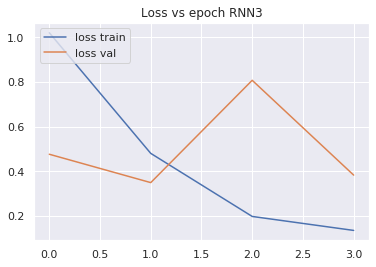

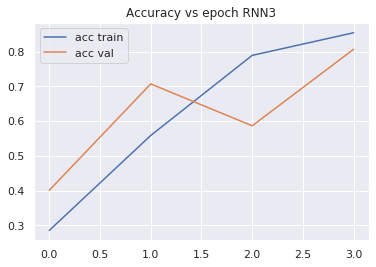


------ Training ------
Accuracy rnn3 : 0.8641081671674405
F1-score None rnn3 : [0.78385506 0.98562127 0.98863944 0.67160834]
F1-score macro rnn3 : 0.8574310282331458

------ Validation ------
Accuracy rnn3 : 0.8065882352941176
F1-score None rnn3 : [0.8877551  0.04494382 0.07058824 0.67446809]
F1-score macro rnn3 : 0.419438810666509

------ Testing ------
Accuracy rnn3 : 0.8111163447951013
F1-score None rnn3 : [0.89669797 0.046875   0.14173228 0.66666667]
F1-score macro rnn3 : 0.4379929801108151

Entrenando exec  3 



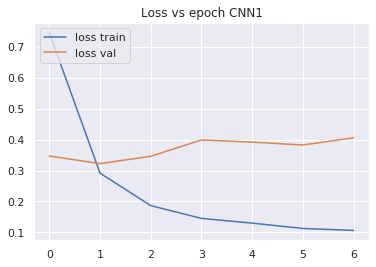

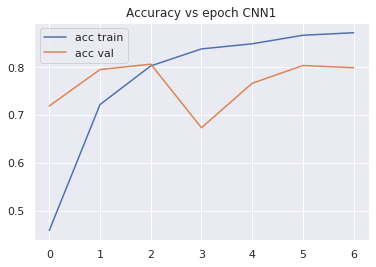


------ Training ------
Accuracy cnn1 : 0.9094509696804152
F1-score None cnn1 : [0.84483627 0.99080049 0.98912894 0.81259194]
F1-score macro cnn1 : 0.9093394110467814

------ Validation ------
Accuracy cnn1 : 0.7990588235294117
F1-score None cnn1 : [0.87684729 0.         0.05       0.66239707]
F1-score macro cnn1 : 0.39731109072963194

------ Testing ------
Accuracy cnn1 : 0.8049929345266132
F1-score None cnn1 : [0.89026658 0.         0.         0.65155131]
F1-score macro cnn1 : 0.3854544741635311


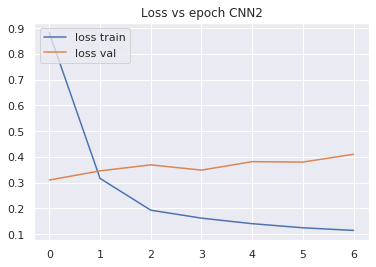

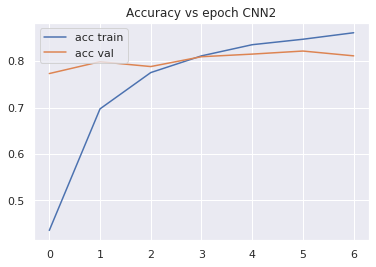


------ Training ------
Accuracy cnn2 : 0.9114313029226987
F1-score None cnn2 : [0.84116162 0.99617382 0.99508465 0.81088314]
F1-score macro cnn2 : 0.9108258068482926

------ Validation ------
Accuracy cnn2 : 0.8112941176470588
F1-score None cnn2 : [0.88756219 0.         0.09756098 0.68449198]
F1-score macro cnn2 : 0.417403785818527

------ Testing ------
Accuracy cnn2 : 0.7946302402260952
F1-score None cnn2 : [0.89085174 0.         0.         0.61521253]
F1-score macro cnn2 : 0.3765160657449947


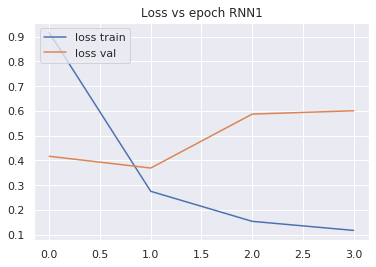

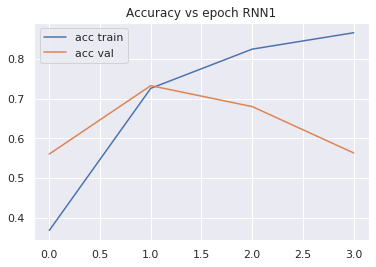


------ Training ------
Accuracy rnn1 : 0.8337885823545479
F1-score None rnn1 : [0.72685714 0.92834256 0.92718754 0.74666667]
F1-score macro rnn1 : 0.8322634766564141

------ Validation ------
Accuracy rnn1 : 0.5632941176470588
F1-score None rnn1 : [0.65177398 0.         0.08403361 0.5369697 ]
F1-score macro rnn1 : 0.31819432300455724

------ Testing ------
Accuracy rnn1 : 0.4479510127178521
F1-score None rnn1 : [0.56612119 0.0173913  0.13793103 0.38044206]
F1-score macro rnn1 : 0.2754713967768247


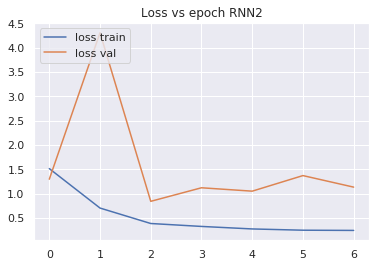

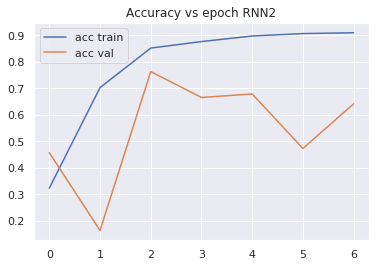


------ Training ------
Accuracy rnn2 : 0.8981835564053537
F1-score None rnn2 : [0.83467862 0.98746729 0.92824544 0.83635387]
F1-score macro rnn2 : 0.8966863062321166

------ Validation ------
Accuracy rnn2 : 0.6414117647058823
F1-score None rnn2 : [0.74437299 0.02597403 0.08064516 0.59290188]
F1-score macro rnn2 : 0.36097351413311285

------ Testing ------
Accuracy rnn2 : 0.5605275553462082
F1-score None rnn2 : [0.69077901 0.         0.23428571 0.44233807]
F1-score macro rnn2 : 0.3418507003159917


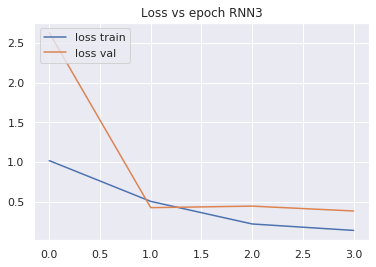

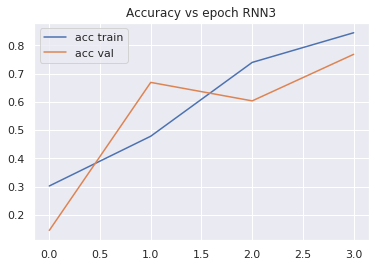


------ Training ------
Accuracy rnn3 : 0.8872575798962032
F1-score None rnn3 : [0.81098843 0.98781478 0.97320561 0.77704132]
F1-score macro rnn3 : 0.8872625366783109

------ Validation ------
Accuracy rnn3 : 0.768
F1-score None rnn3 : [0.85293085 0.08247423 0.03030303 0.66558966]
F1-score macro rnn3 : 0.40782444269528517

------ Testing ------
Accuracy rnn3 : 0.712670748940179
F1-score None rnn3 : [0.8257133  0.13414634 0.1147541  0.55946717]
F1-score macro rnn3 : 0.40852022937117294

Entrenando exec  4 



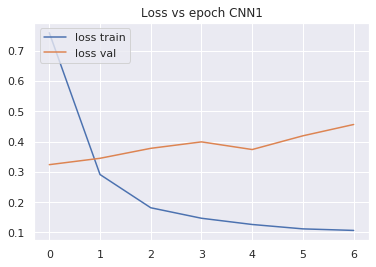

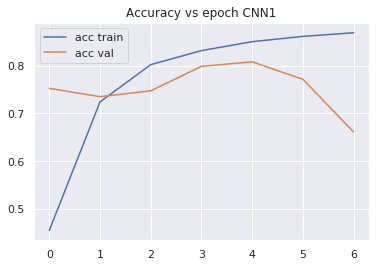


------ Training ------
Accuracy cnn1 : 0.924064463261404
F1-score None cnn1 : [0.84096314 0.99494328 0.99686862 0.86148392]
F1-score macro cnn1 : 0.9235647399933886

------ Validation ------
Accuracy cnn1 : 0.6611764705882353
F1-score None cnn1 : [0.74741036 0.         0.0952381  0.57195572]
F1-score macro cnn1 : 0.353651043340257

------ Testing ------
Accuracy cnn1 : 0.567593028732925
F1-score None cnn1 : [0.69331223 0.         0.05063291 0.42633638]
F1-score macro cnn1 : 0.2925703787048974


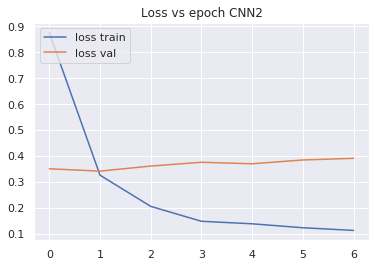

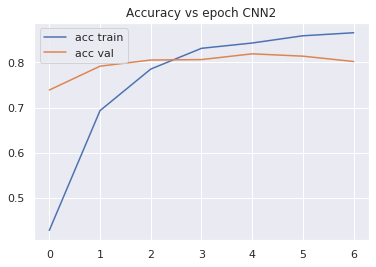


------ Training ------
Accuracy cnn2 : 0.9190794864791041
F1-score None cnn2 : [0.85193798 0.99522445 0.99659632 0.83066628]
F1-score macro cnn2 : 0.918606259517343

------ Validation ------
Accuracy cnn2 : 0.8018823529411765
F1-score None cnn2 : [0.87886945 0.         0.09756098 0.67982833]
F1-score macro cnn2 : 0.4140646874932638

------ Testing ------
Accuracy cnn2 : 0.7724917569477155
F1-score None cnn2 : [0.87154785 0.         0.02469136 0.5968254 ]
F1-score macro cnn2 : 0.3732661508191374


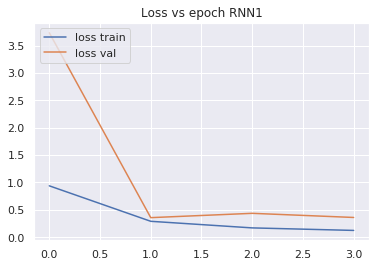

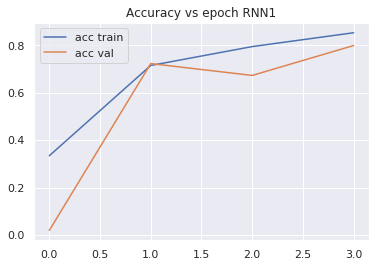


------ Training ------
Accuracy rnn1 : 0.8562551215514886
F1-score None rnn1 : [0.78138027 0.96575433 0.98268279 0.66678135]
F1-score macro rnn1 : 0.8491496859550297

------ Validation ------
Accuracy rnn1 : 0.7990588235294117
F1-score None rnn1 : [0.88240948 0.07692308 0.06666667 0.66879659]
F1-score macro rnn1 : 0.4236989549621795

------ Testing ------
Accuracy rnn1 : 0.8130004710315591
F1-score None rnn1 : [0.89659367 0.17486339 0.10526316 0.69591528]
F1-score macro rnn1 : 0.4681588749294467


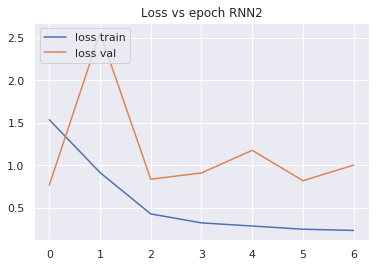

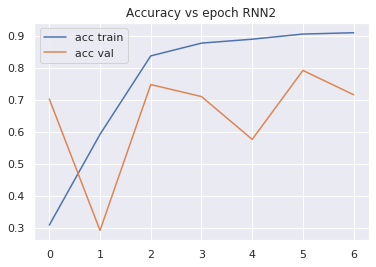


------ Training ------
Accuracy rnn2 : 0.934444140945097
F1-score None rnn2 : [0.87510572 0.98480161 0.99375339 0.88167681]
F1-score macro rnn2 : 0.933834385170698

------ Validation ------
Accuracy rnn2 : 0.7162352941176471
F1-score None rnn2 : [0.80688623 0.1641791  0.04210526 0.63899185]
F1-score macro rnn2 : 0.4130406102480323

------ Testing ------
Accuracy rnn2 : 0.6556759302873293
F1-score None rnn2 : [0.77594426 0.17475728 0.12903226 0.52849741]
F1-score macro rnn2 : 0.40205780250927875


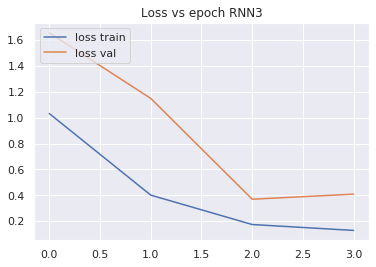

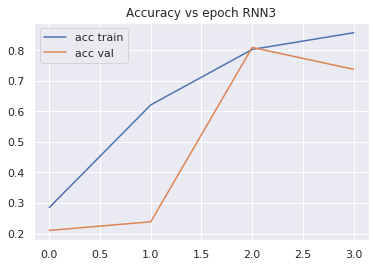


------ Training ------
Accuracy rnn3 : 0.8988664299371756
F1-score None rnn3 : [0.81865842 0.98353965 0.98854337 0.80351661]
F1-score macro rnn3 : 0.8985645135044228

------ Validation ------
Accuracy rnn3 : 0.7378823529411764
F1-score None rnn3 : [0.82626043 0.01960784 0.06451613 0.64108352]
F1-score macro rnn3 : 0.3878669804039148

------ Testing ------
Accuracy rnn3 : 0.6933584550164861
F1-score None rnn3 : [0.80969351 0.21556886 0.19130435 0.53022453]
F1-score macro rnn3 : 0.43669781226087556

Entrenando exec  5 



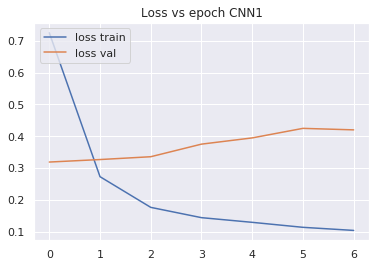

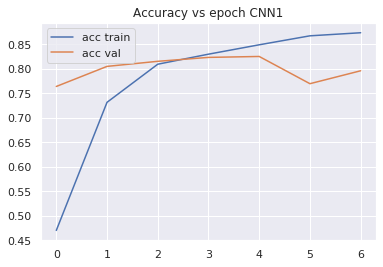


------ Training ------
Accuracy cnn1 : 0.9242010379677684
F1-score None cnn1 : [0.859236   0.99577714 0.9965954  0.84367816]
F1-score macro cnn1 : 0.9238216755170334

------ Validation ------
Accuracy cnn1 : 0.7957647058823529
F1-score None cnn1 : [0.87449118 0.         0.0952381  0.67340067]
F1-score macro cnn1 : 0.41078248727502453

------ Testing ------
Accuracy cnn1 : 0.7668393782383419
F1-score None cnn1 : [0.86902827 0.         0.         0.59026369]
F1-score macro cnn1 : 0.3648229914941782


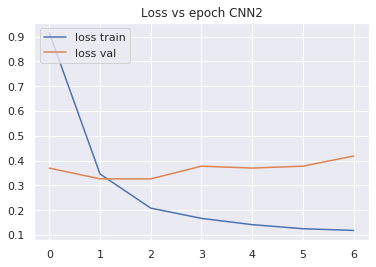

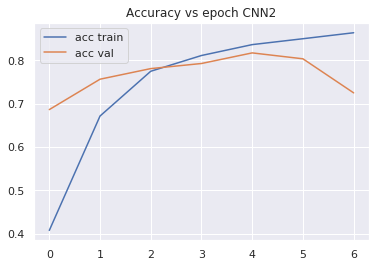


------ Training ------
Accuracy cnn2 : 0.9207183829554767
F1-score None cnn2 : [0.83935456 0.99481583 0.99672578 0.85114754]
F1-score macro cnn2 : 0.9205109282841707

------ Validation ------
Accuracy cnn2 : 0.7247058823529412
F1-score None cnn2 : [0.811356   0.         0.09756098 0.61917808]
F1-score macro cnn2 : 0.38202376332972676

------ Testing ------
Accuracy cnn2 : 0.6617993405558172
F1-score None cnn2 : [0.78699306 0.         0.02597403 0.49321267]
F1-score macro cnn2 : 0.3265449384375216


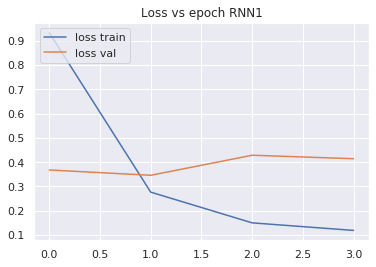

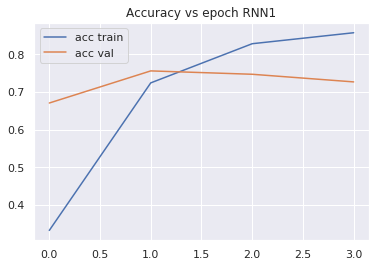


------ Training ------
Accuracy rnn1 : 0.8893744878448512
F1-score None rnn1 : [0.80469613 0.96353824 0.9855551  0.7989418 ]
F1-score macro rnn1 : 0.8881828168260388

------ Validation ------
Accuracy rnn1 : 0.7265882352941176
F1-score None rnn1 : [0.82185792 0.08284024 0.04166667 0.63354037]
F1-score macro rnn1 : 0.39497629988028304

------ Testing ------
Accuracy rnn1 : 0.6999528968440886
F1-score None rnn1 : [0.81319444 0.21800948 0.08695652 0.54186265]
F1-score macro rnn1 : 0.4150057744314496


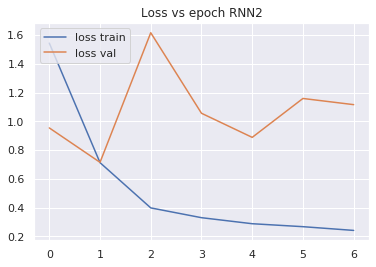

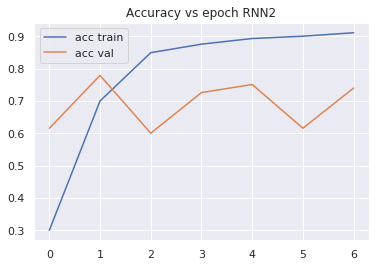


------ Training ------
Accuracy rnn2 : 0.897568970226714
F1-score None rnn2 : [0.8400703  0.97082228 0.97966283 0.78535193]
F1-score macro rnn2 : 0.8939768362842143

------ Validation ------
Accuracy rnn2 : 0.7402352941176471
F1-score None rnn2 : [0.84628552 0.09326425 0.02898551 0.65330661]
F1-score macro rnn2 : 0.4054604719588717

------ Testing ------
Accuracy rnn2 : 0.7583608101742817
F1-score None rnn2 : [0.86334197 0.15023474 0.15686275 0.62878788]
F1-score macro rnn2 : 0.44980683364546814


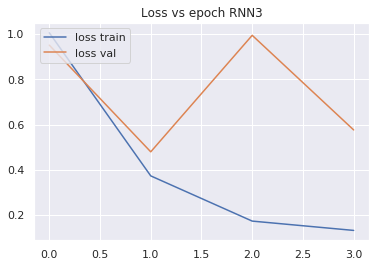

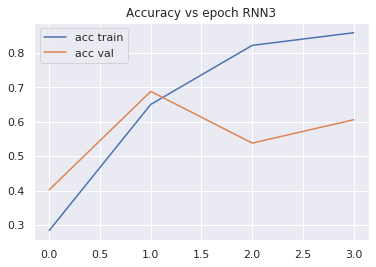


------ Training ------
Accuracy rnn3 : 0.8822043157607211
F1-score None rnn3 : [0.77651747 0.97271396 0.96638767 0.80139824]
F1-score macro rnn3 : 0.8792543366781457

------ Validation ------
Accuracy rnn3 : 0.6056470588235294
F1-score None rnn3 : [0.70108243 0.10843373 0.0397351  0.56564337]
F1-score macro rnn3 : 0.3537236589827325

------ Testing ------
Accuracy rnn3 : 0.4950541686292982
F1-score None rnn3 : [0.60214133 0.23580786 0.16831683 0.41081081]
F1-score macro rnn3 : 0.3542692075947786


In [27]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [28]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 BERT Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 BERT Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 BERT Ponderado - Accuracy promedio para",key,":" ,temp/5)

0.15 BERT Ponderado - F1-score promedio para cnn1 : [0.8533288  0.         0.02051619 0.60795685]
0.15 BERT Ponderado - F1-score promedio para cnn2 : [0.83933154 0.         0.02558429 0.55834794]
0.15 BERT Ponderado - F1-score promedio para rnn1 : [0.61036831 0.15213125 0.12953263 0.47675539]
0.15 BERT Ponderado - F1-score promedio para rnn2 : [0.70033656 0.1253241  0.16509295 0.48714785]
0.15 BERT Ponderado - F1-score promedio para rnn3 : [0.74499561 0.12989842 0.14226913 0.51180118]

0.15 BERT Ponderado - F1-score macro promedio para cnn1 : 0.3704504614078531 desvest:  0.04166671022423095
0.15 BERT Ponderado - F1-score macro promedio para cnn2 : 0.35581594290218616 desvest:  0.025344601798193114
0.15 BERT Ponderado - F1-score macro promedio para rnn1 : 0.34219689412497994 desvest:  0.09456559808694104
0.15 BERT Ponderado - F1-score macro promedio para rnn2 : 0.36947536459108954 desvest:  0.06143973599348355
0.15 BERT Ponderado - F1-score macro promedio para rnn3 : 0.38224108414780156